random up down sample all islands 

In [24]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib

In [25]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [26]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Sha

In [27]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [28]:
# Ensure 'walrus_pure' and 'walrus_mixed' are in the list of classes
if 'walrus_pure' in le.classes_ and 'walrus_mixed' in le.classes_:
    walrus_pure_index = np.where(le.classes_ == 'walrus_pure')[0][0]
    walrus_mixed_index = np.where(le.classes_ == 'walrus_mixed')[0][0]
    
    walrus_pure_count = np.sum(encoded_labels == walrus_pure_index)
    walrus_mixed_count = np.sum(encoded_labels == walrus_mixed_index)
    walrus_count = max(walrus_pure_count, walrus_mixed_count)

    # Upsample 'walrus_pure' to match 'walrus_mixed'
    walrus_pure_features = features[encoded_labels == walrus_pure_index]
    walrus_pure_labels = encoded_labels[encoded_labels == walrus_pure_index]
    walrus_mixed_features = features[encoded_labels == walrus_mixed_index]
    walrus_mixed_labels = encoded_labels[encoded_labels == walrus_mixed_index]

    if walrus_pure_count < walrus_mixed_count:
        walrus_pure_features, walrus_pure_labels = resample(
            walrus_pure_features, walrus_pure_labels,
            replace=True,
            n_samples=walrus_mixed_count,
            random_state=42
        )
    elif walrus_pure_count > walrus_mixed_count:
        walrus_mixed_features, walrus_mixed_labels = resample(
            walrus_mixed_features, walrus_mixed_labels,
            replace=True,
            n_samples=walrus_pure_count,
            random_state=42
        )

    # Downsample other classes to match the number of 'walrus' pixels
    downsampled_features = []
    downsampled_labels = []

    walrus_features = np.vstack([walrus_pure_features, walrus_mixed_features])
    walrus_labels = np.hstack([walrus_pure_labels, walrus_mixed_labels])

    for class_index in np.unique(encoded_labels):
        class_features = features[encoded_labels == class_index]
        class_labels = encoded_labels[encoded_labels == class_index]
        
        if class_index in [walrus_pure_index, walrus_mixed_index]:
            downsampled_features.append(class_features)
            downsampled_labels.append(class_labels)
        else:
            downsampled_class_features, downsampled_class_labels = resample(
                class_features, class_labels, 
                replace=False, 
                n_samples=walrus_count, 
                random_state=42
            )
            downsampled_features.append(downsampled_class_features)
            downsampled_labels.append(downsampled_class_labels)

    features = np.vstack([walrus_features] + downsampled_features)
    encoded_labels = np.hstack([walrus_labels] + downsampled_labels)
else:
    print("'walrus_pure' or 'walrus_mixed' class not found in the labels. Please check your data.")
    # Handle the case where 'walrus_pure' or 'walrus_mixed' class is not found, e.g., raise an error or proceed without downsampling
    raise ValueError("'walrus_pure' or 'walrus_mixed' class not found in the labels. Please check your data.")


In [29]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Save the model
model_filename = "RF_allislands_random_updownsamp.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.90      0.90      0.90       150
         ice       0.89      0.82      0.86       163
       ocean       0.99      0.98      0.98       161
        rock       0.98      0.86      0.91       152
walrus_mixed       0.90      0.99      0.94       334
 walrus_pure       0.99      1.00      1.00       201

    accuracy                           0.94      1161
   macro avg       0.94      0.92      0.93      1161
weighted avg       0.94      0.94      0.94      1161


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


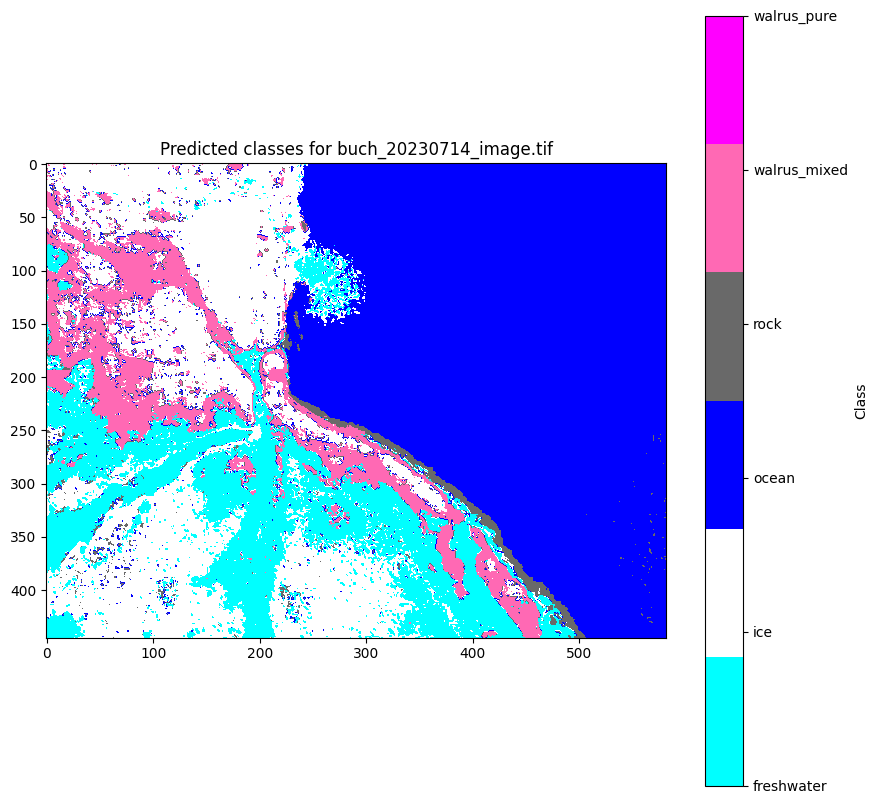

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


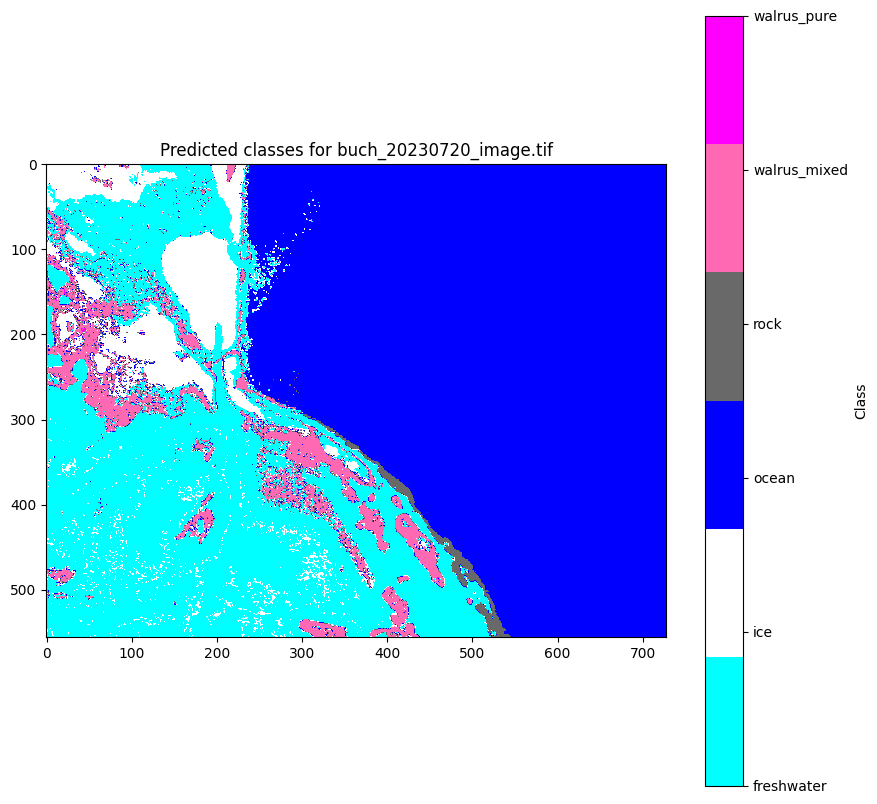

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


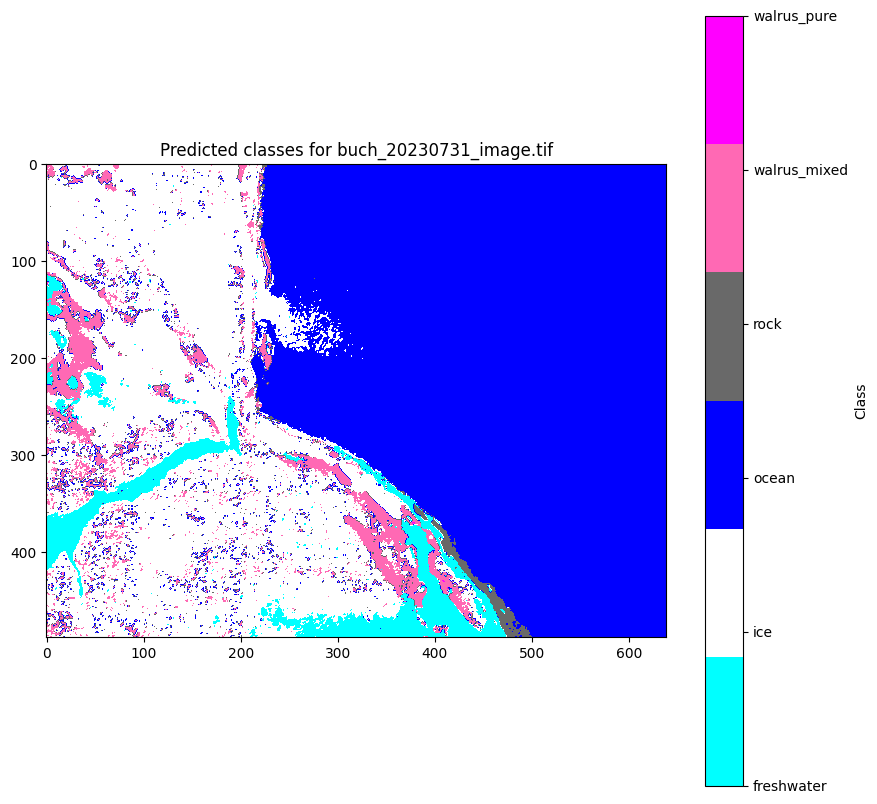

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


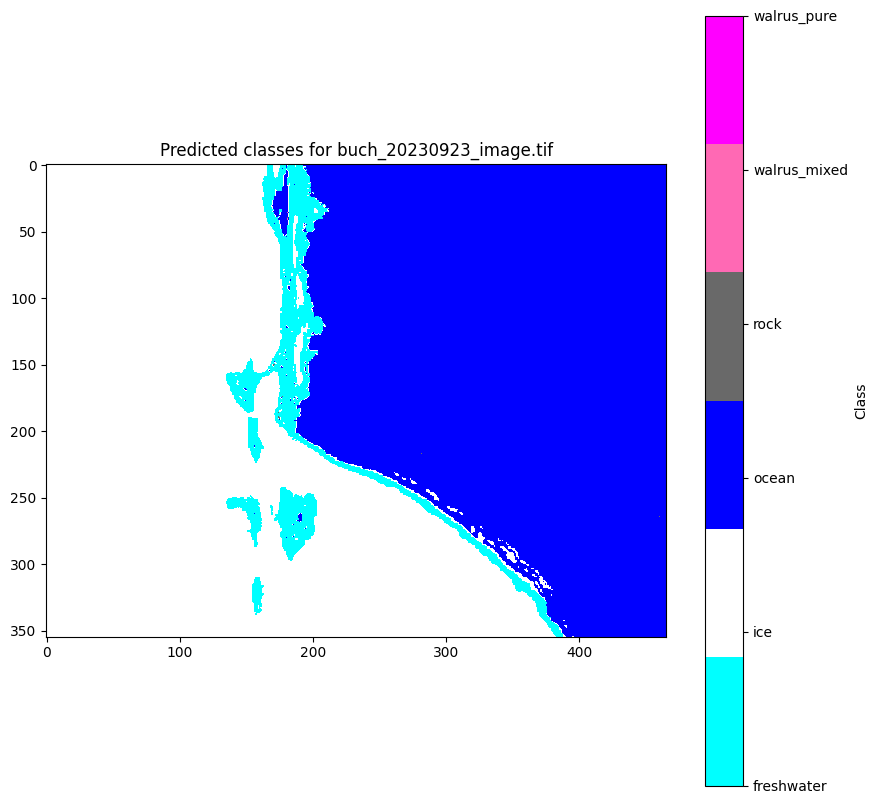

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


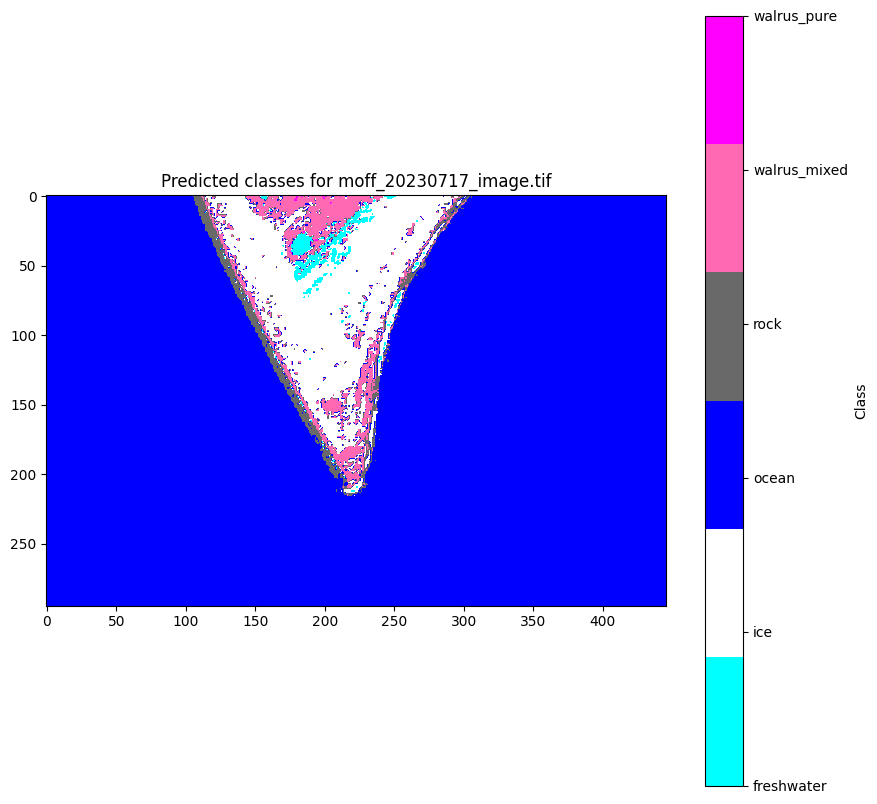

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


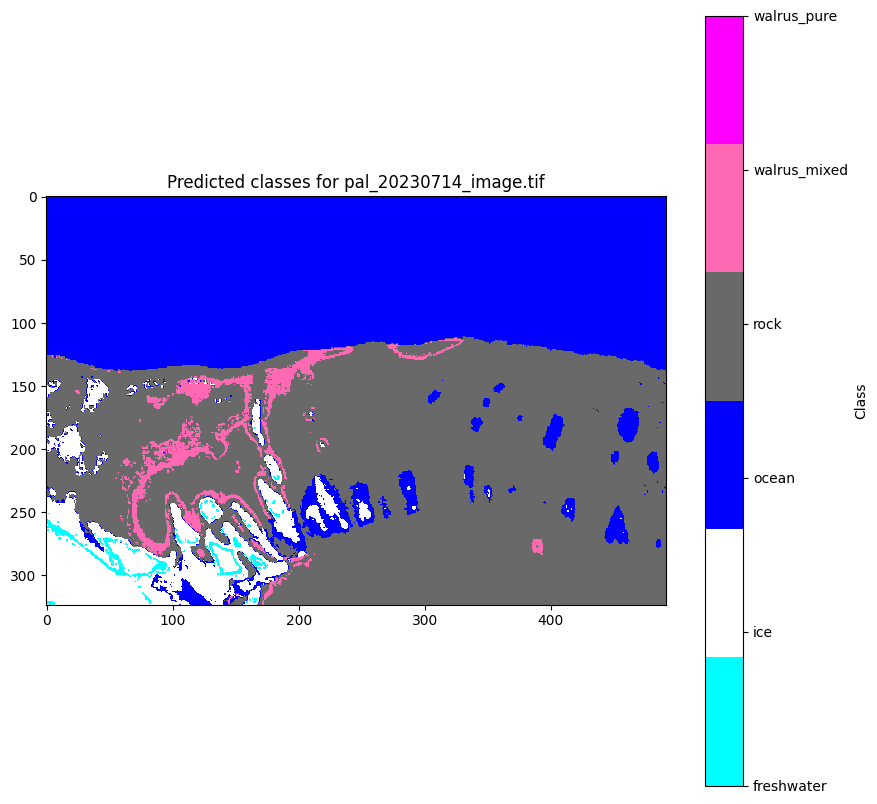

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


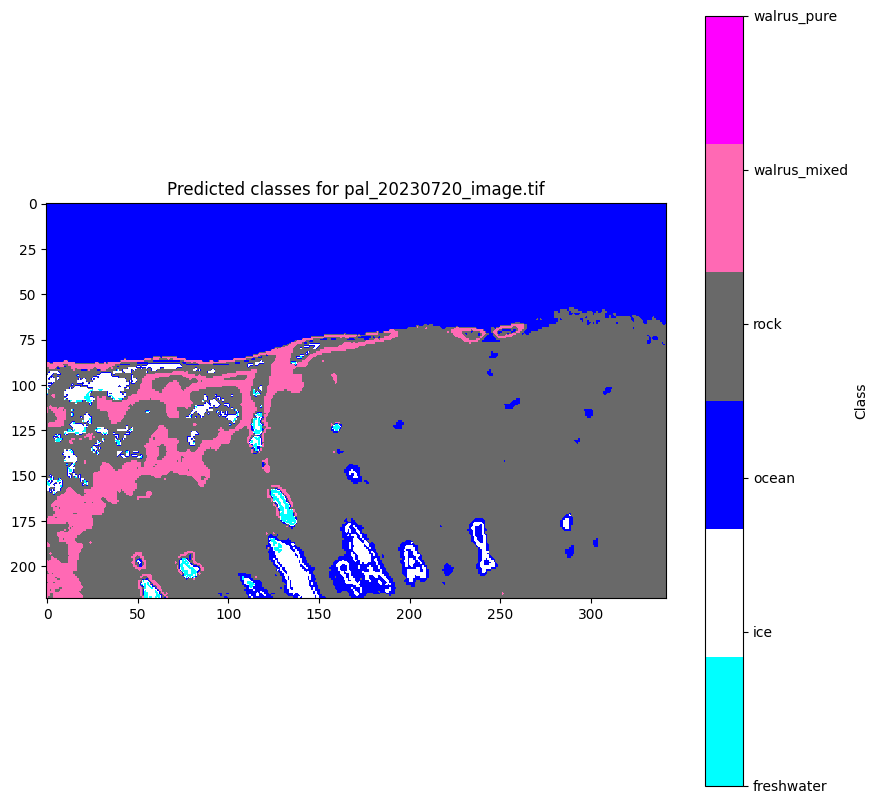

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


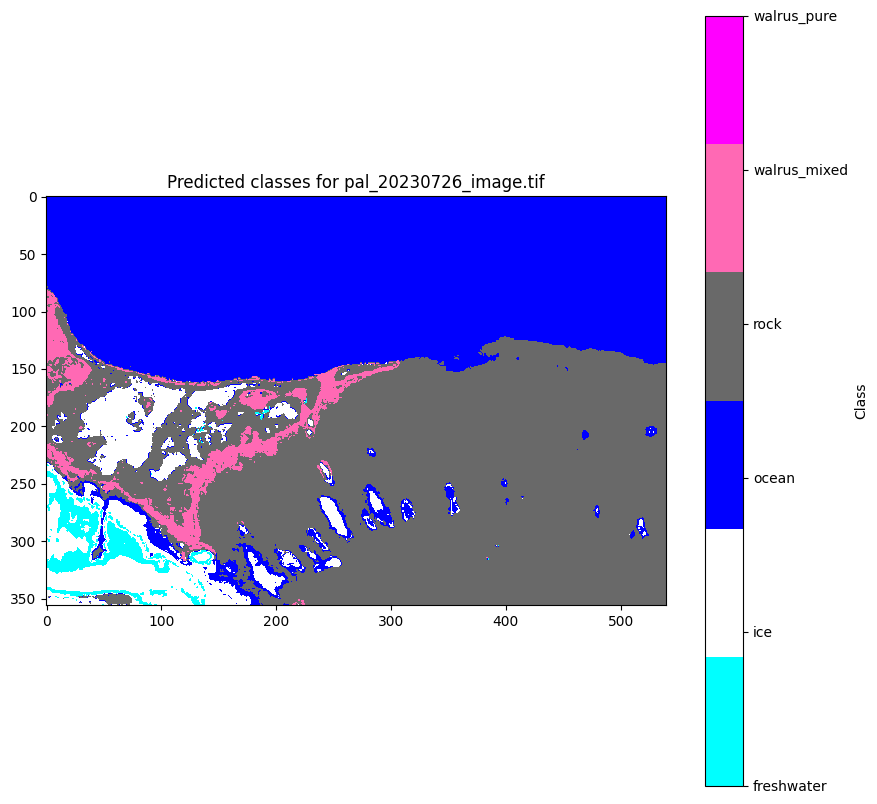

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


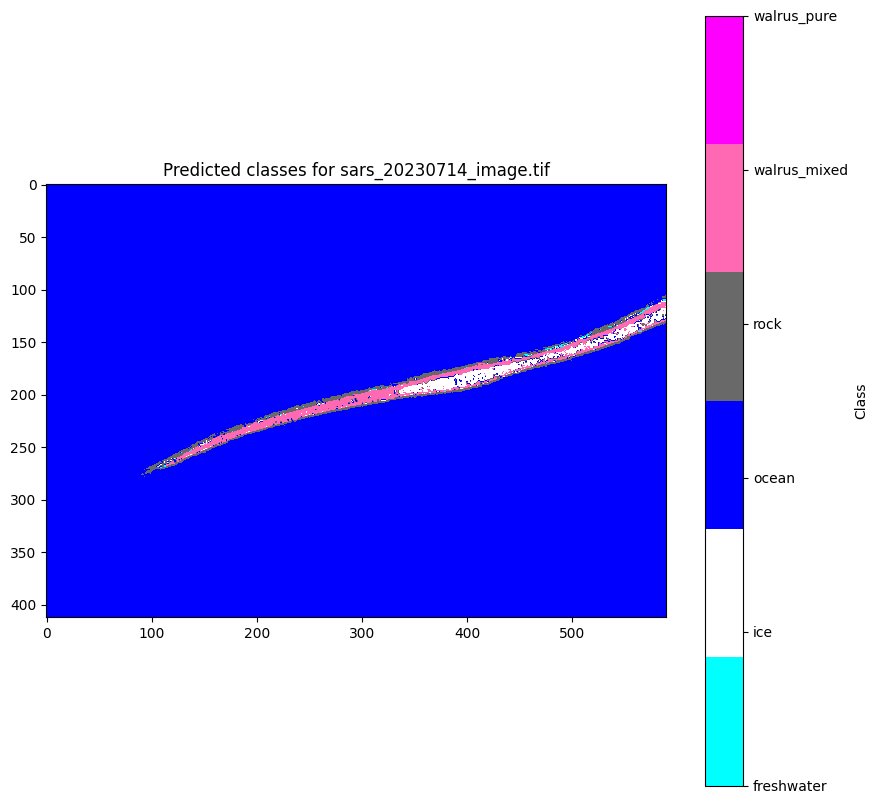

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


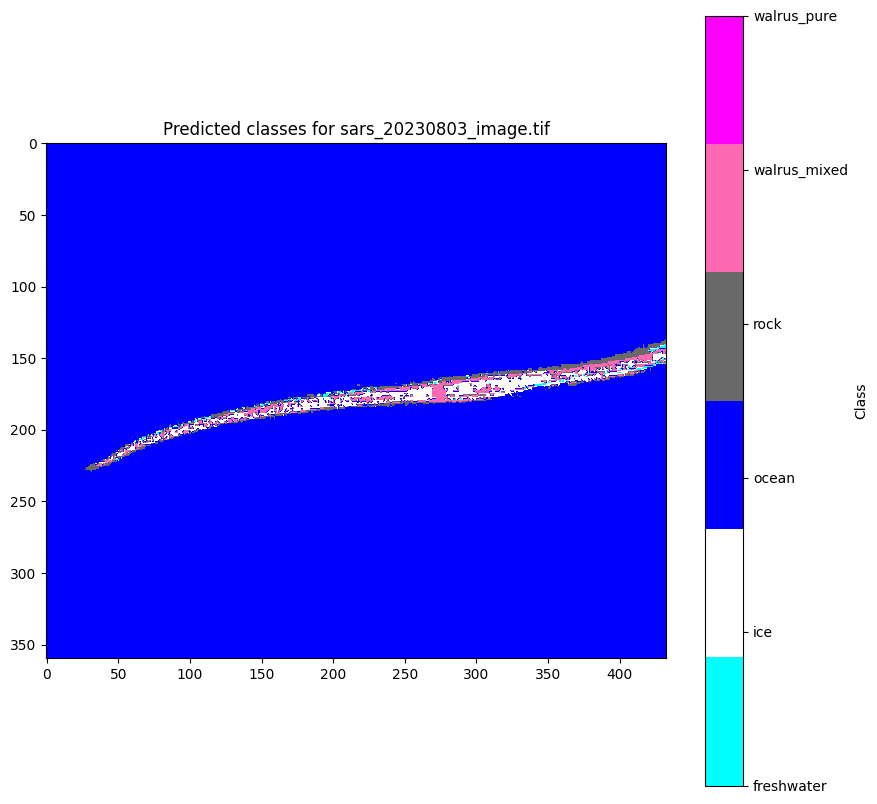

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


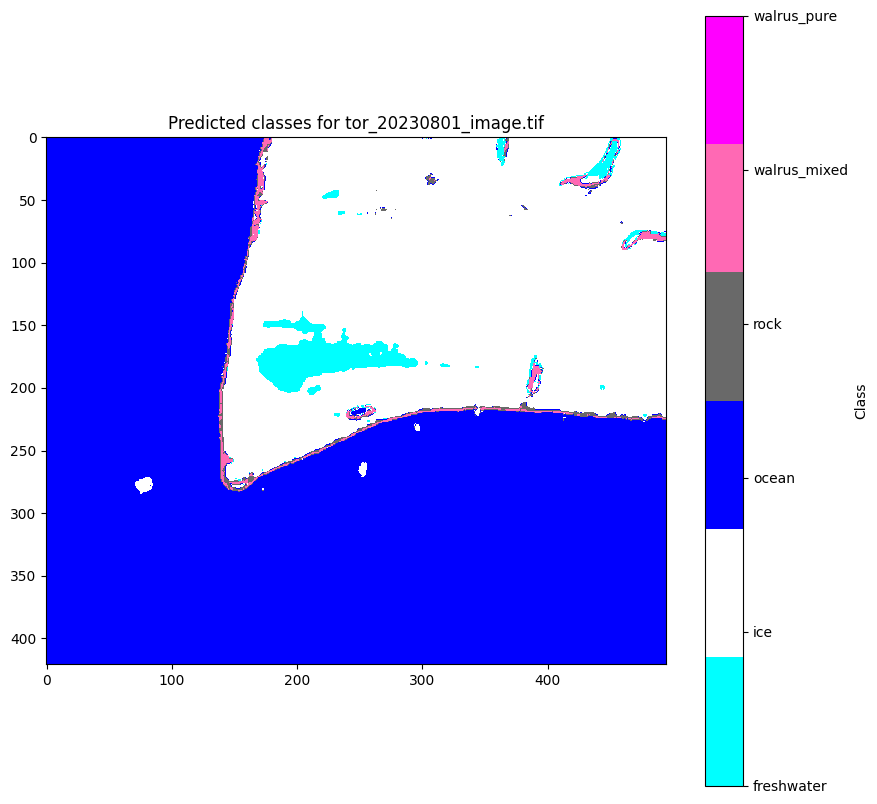

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


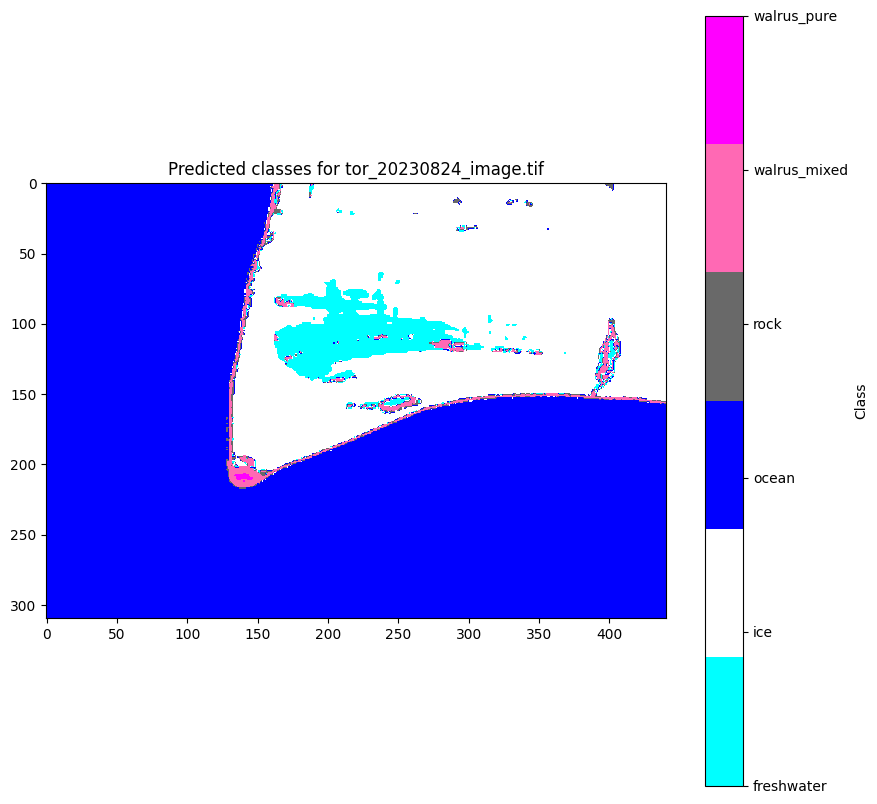

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


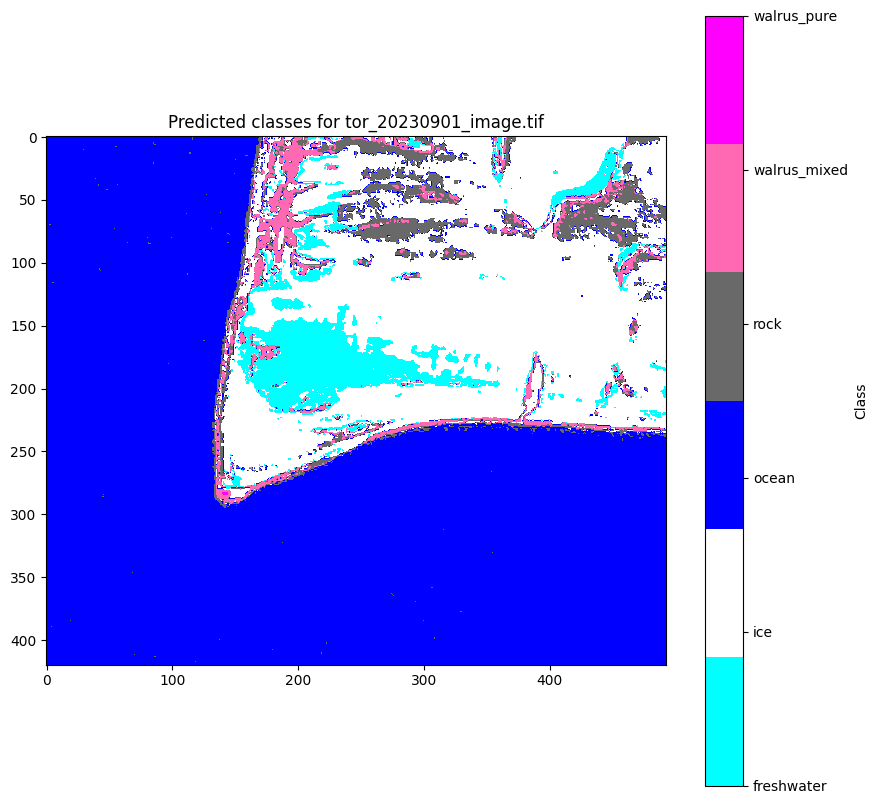

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


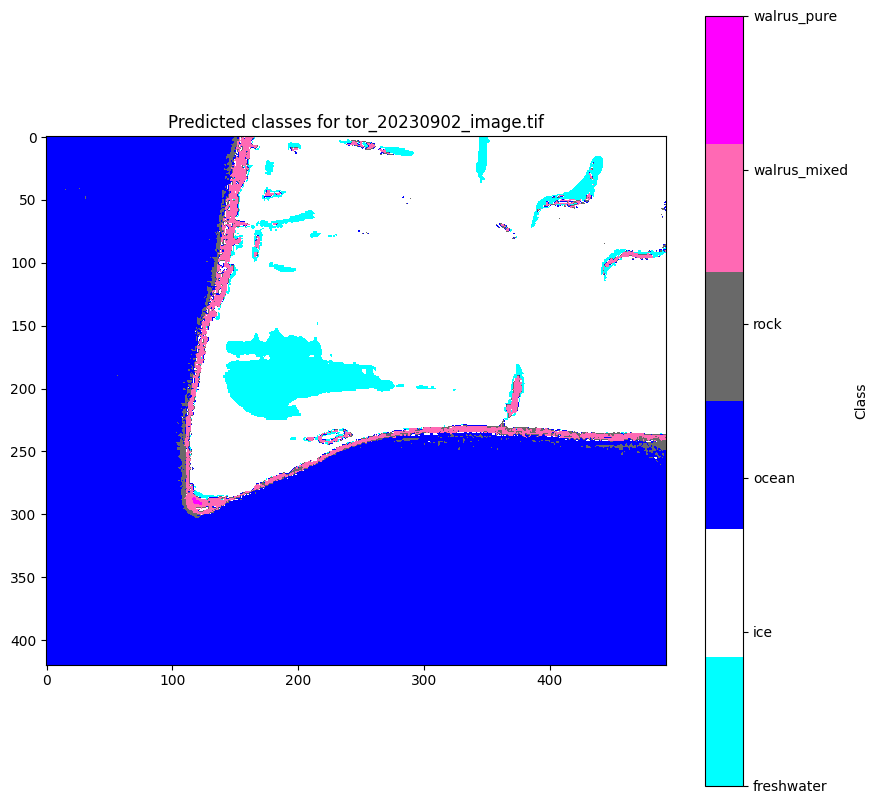

In [31]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [32]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from RF_allislands_random_updownsamp.joblib


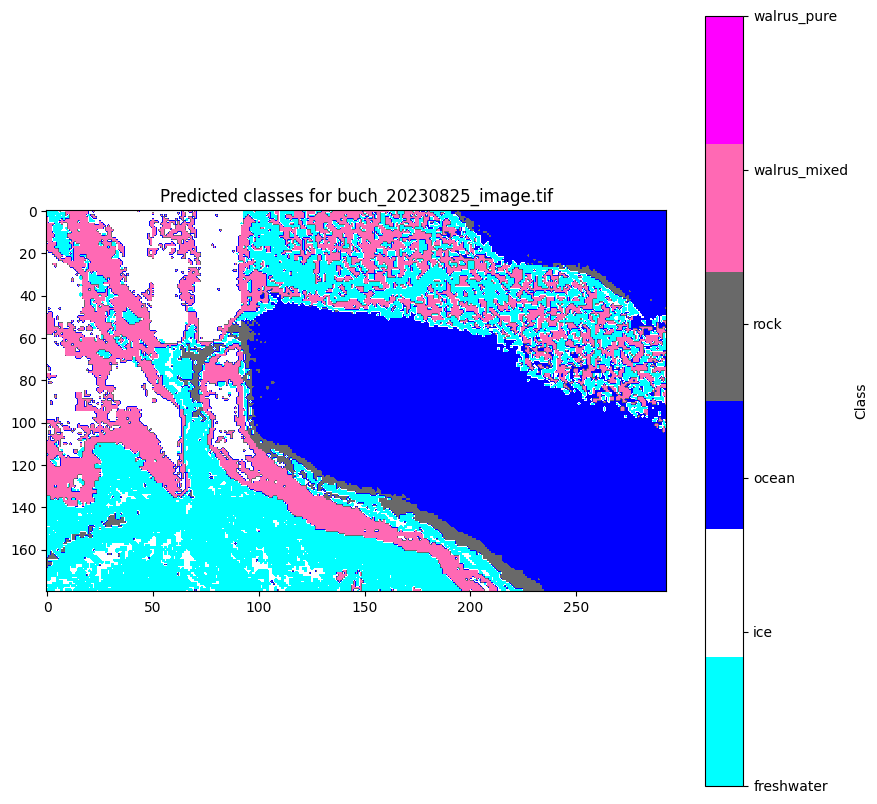

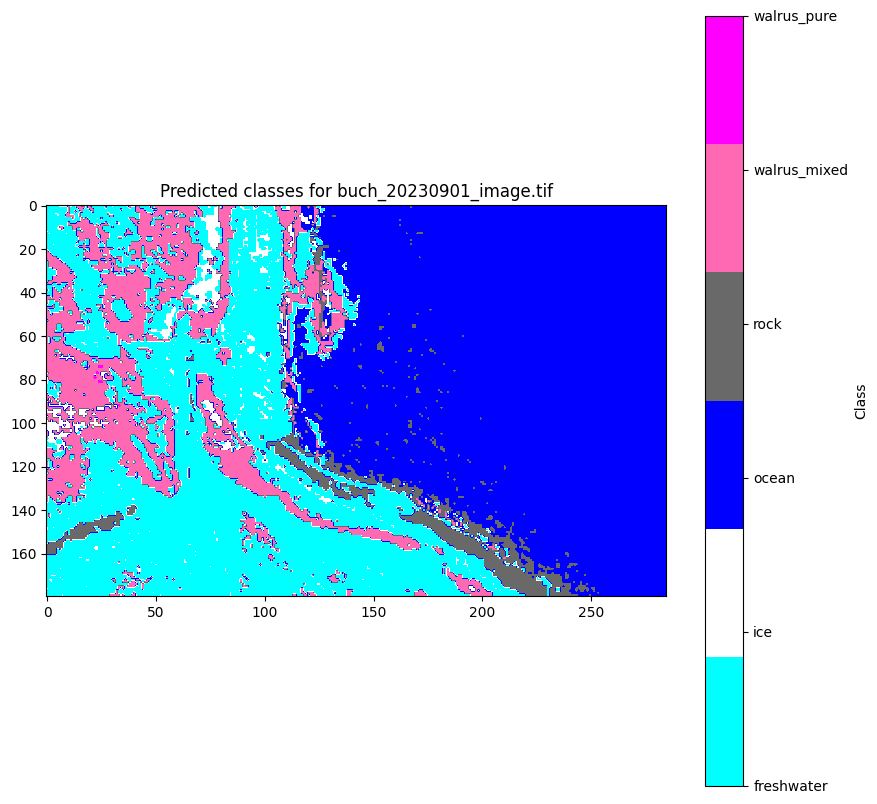

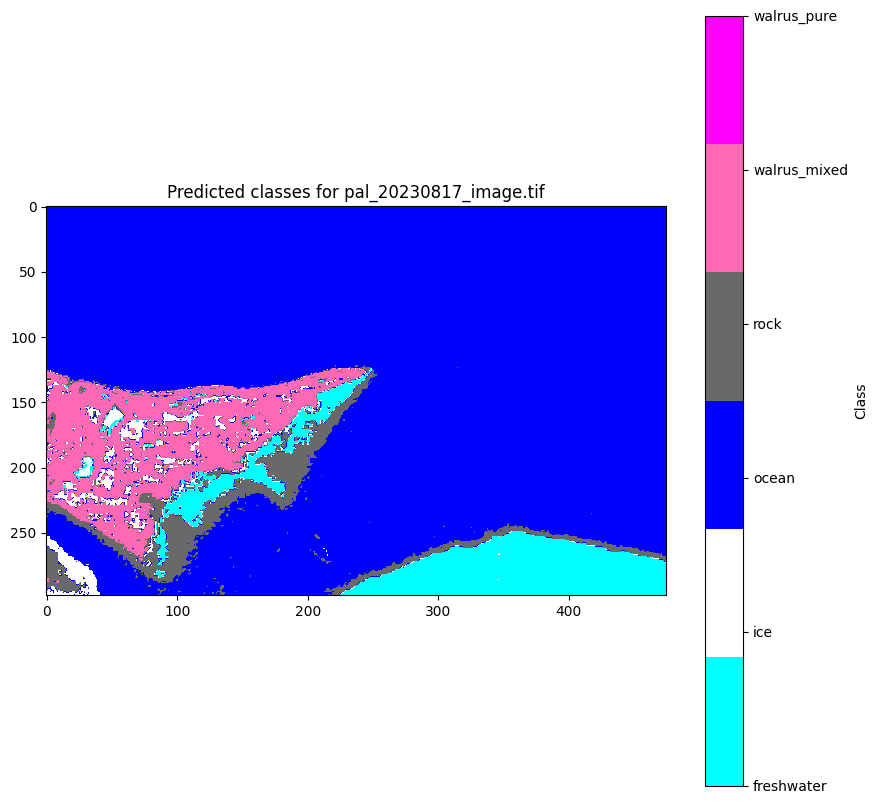

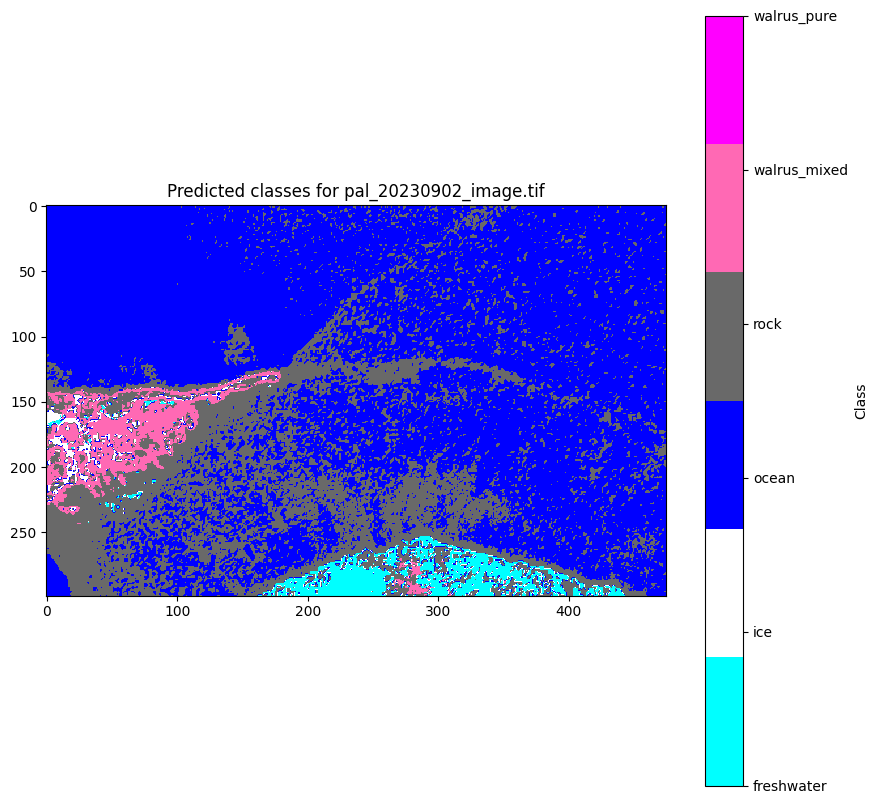

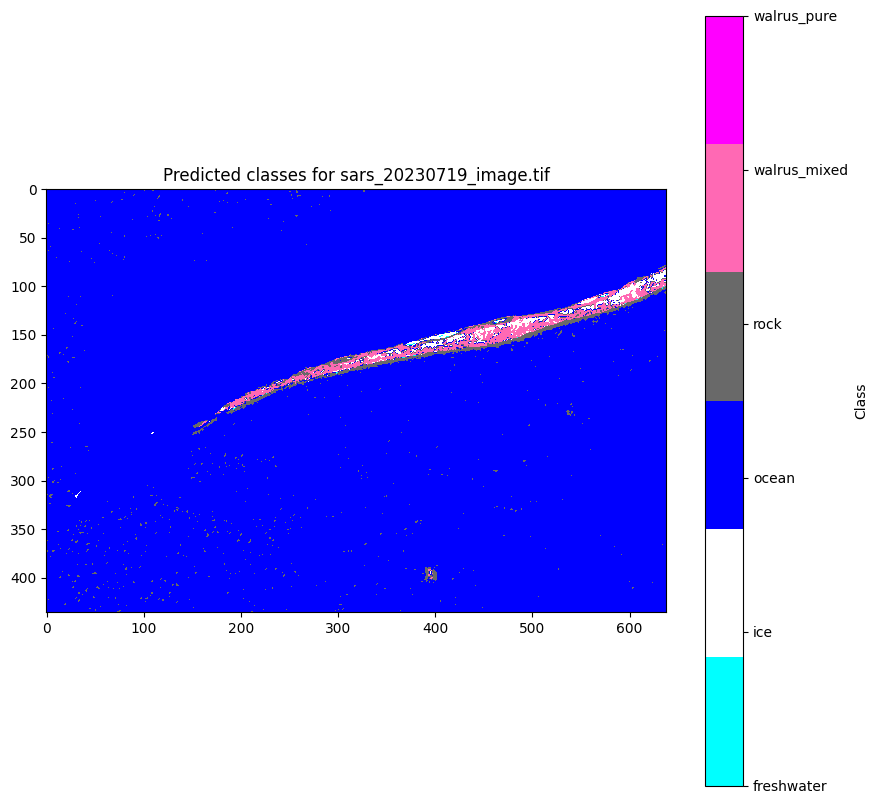

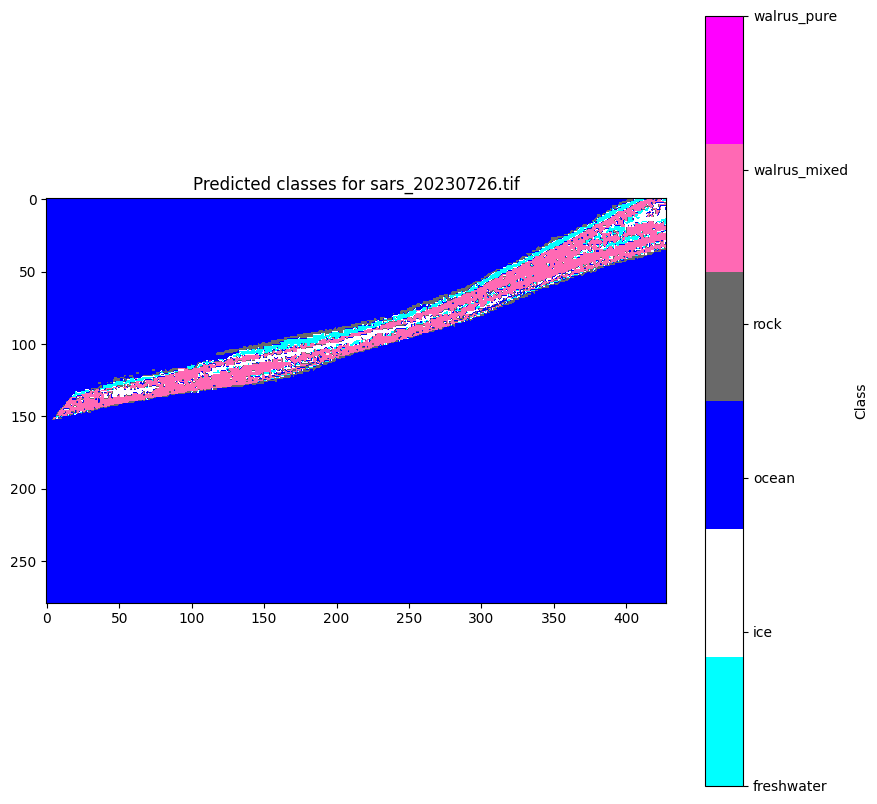

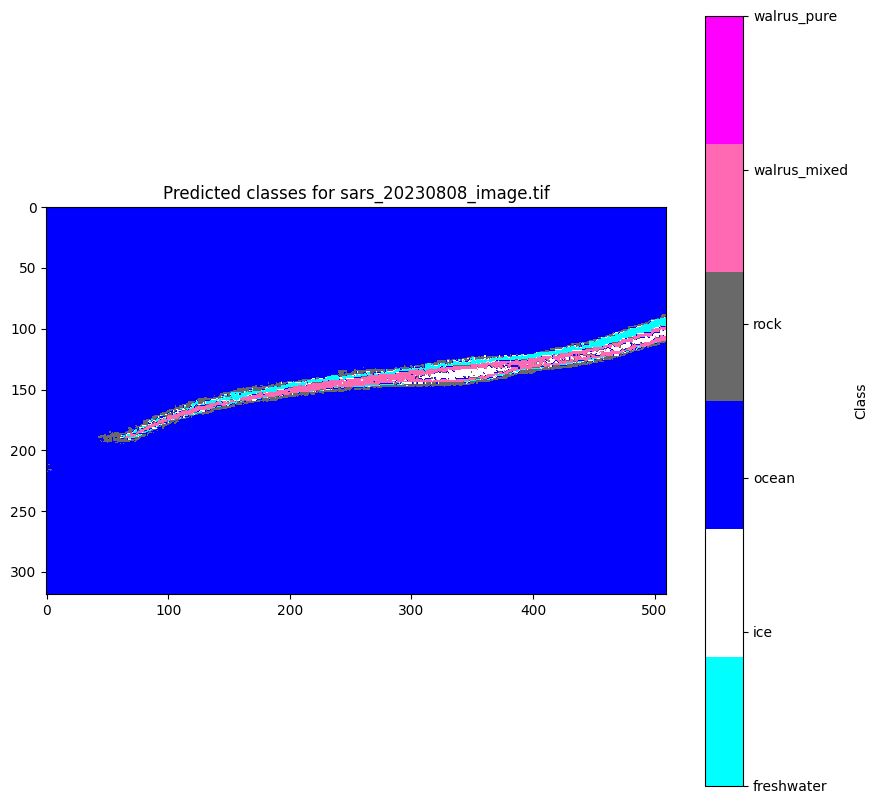

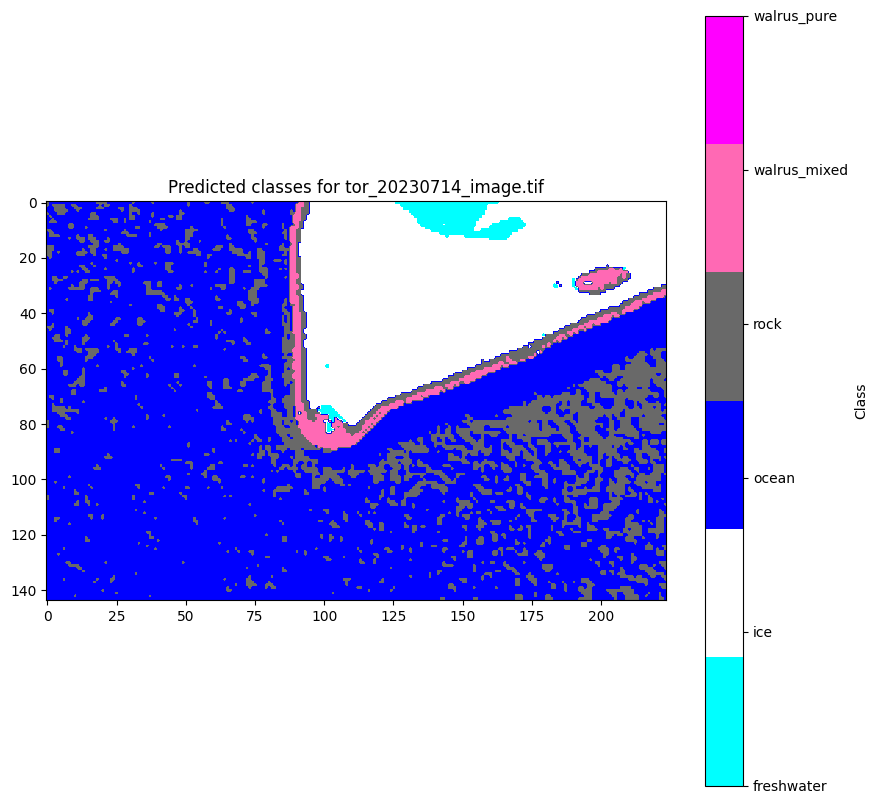

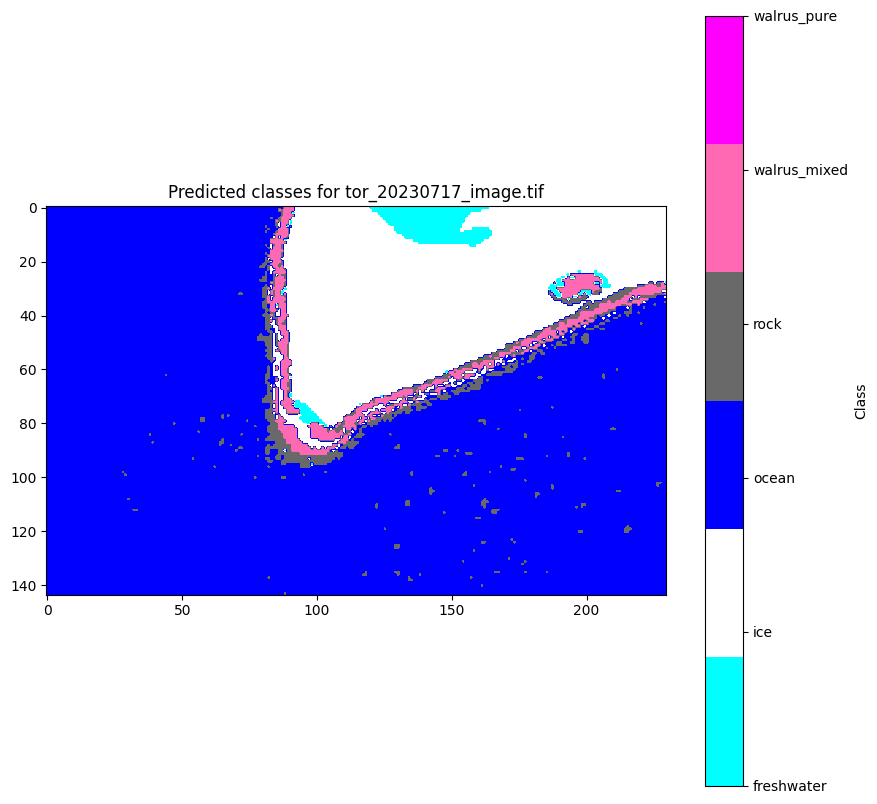

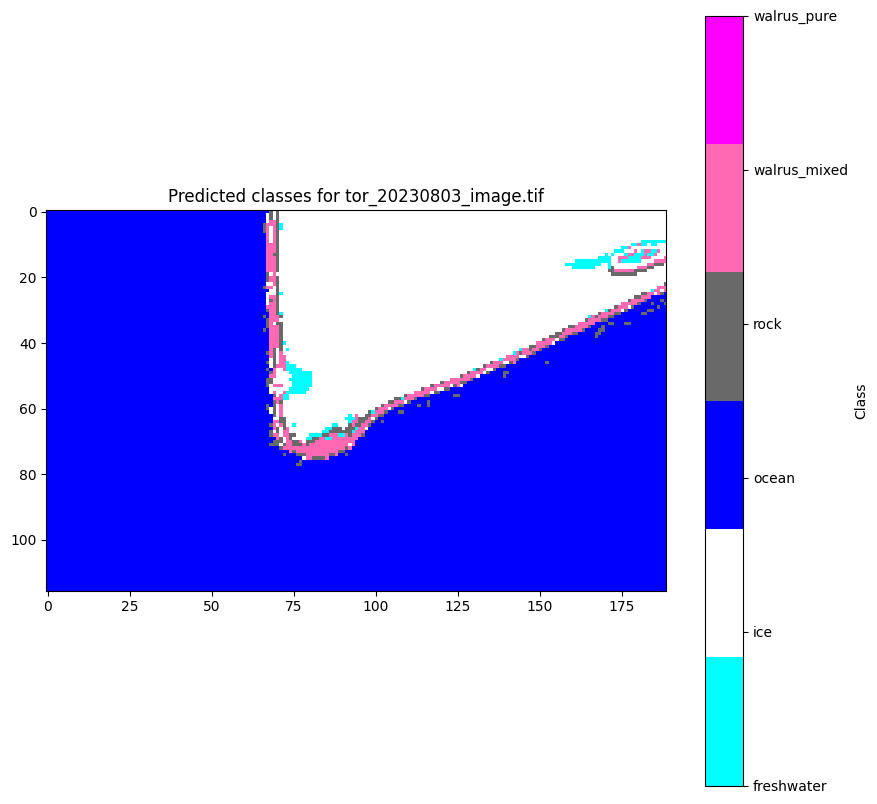

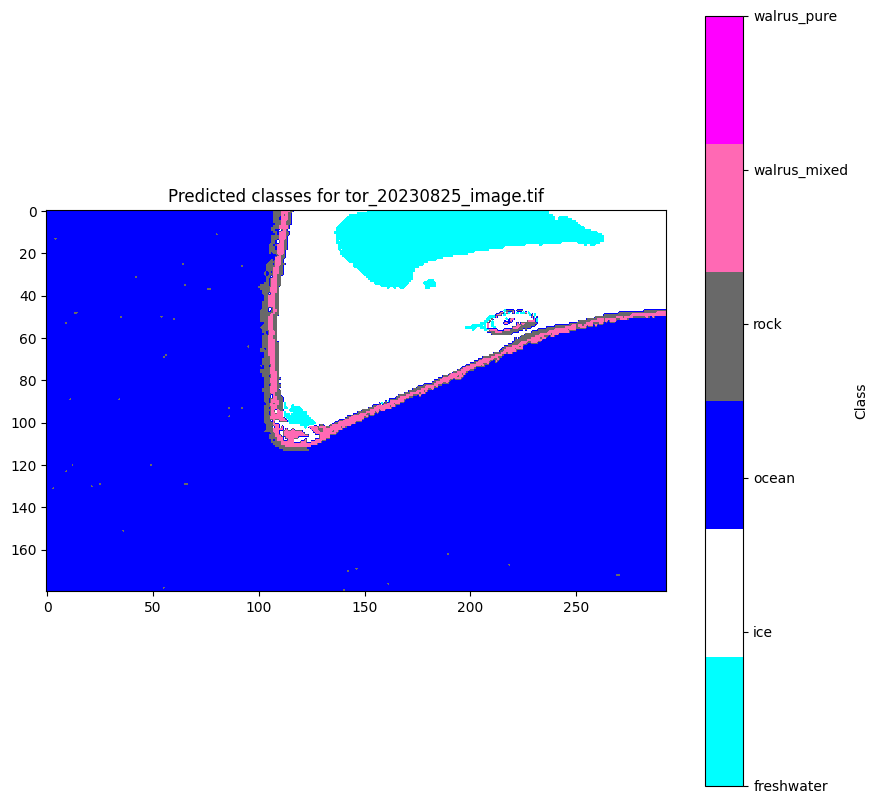

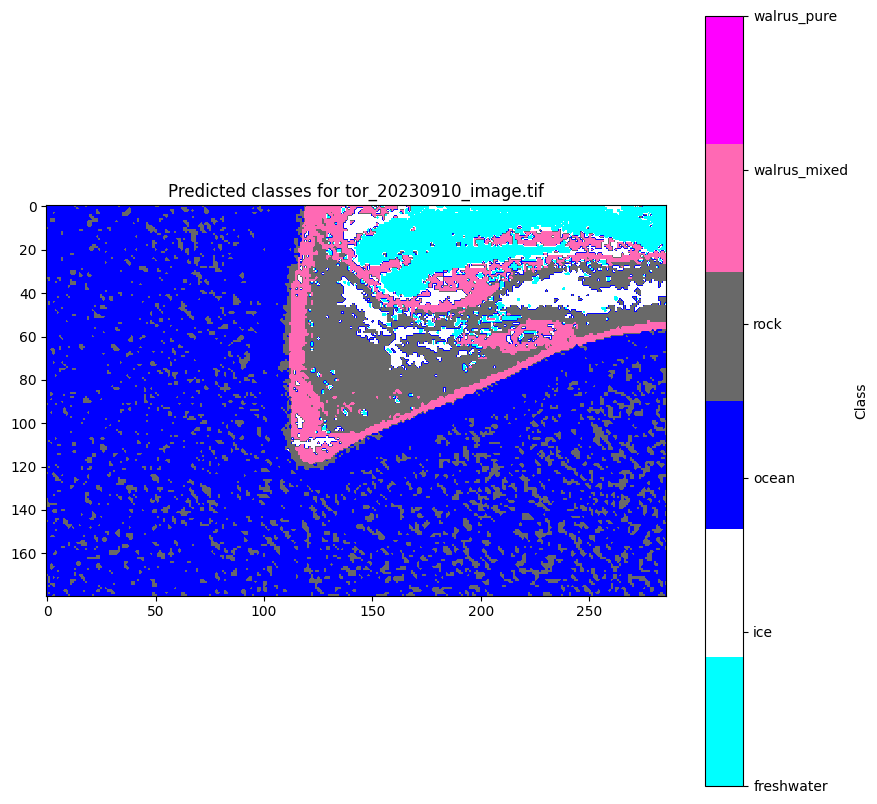

In [33]:
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()


 Intelligent resmapling using imblean.over_sampling.SMOTE

In [35]:
!pip install imblearn

  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/5a/fa/267de06c95210580f4b82b45cec1ce1e9ce1f21a01a684367db89e7da70d/imbalanced_learn-0.12.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   --------------------------------------- 258.3/258.3 kB 15.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib

In [61]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)
    
    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []


for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)


features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Sha

In [47]:
import pandas as pd

In [50]:
features.shape

(1213496, 8)

In [51]:
labels.shape

(1213496,)

In [62]:
len(image_name)

1213496

In [63]:
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels' : labels, 
                        'image_name' : image_name})

In [64]:
dataset

Coast_blue  Blue  Green1  Green  Yellow   Red  Red_edge   NIR  \
0              1187   980    1269   1220    1517  1329      1416  1650   
1              1148   912    1212   1128    1440  1240      1297  1612   
2              1131   856    1162   1128    1426  1181      1355  1510   
3              1134   856    1156   1086    1384  1146      1275  1536   
4              1127   868    1149   1053    1348  1138      1250  1556   
...             ...   ...     ...    ...     ...   ...       ...   ...   
1213491        1653  1826    1875   1818    2156  1993      2191  2626   
1213492        1695  1837    1872   1866    2230  2013      2222  2628   
1213493        1730  1870    1929   1941    2259  2091      2276  2647   
1213494        1634  1851    1879   1895    2200  2053      2281  2634   
1213495        1720  1904    1905   1983    2300  2135      2316  2654   

               labels                                         image_name  
0        walrus_mixed  C:\Users\Student\Documents\101_walrus_data\tra...  
1        walrus_mixed  C:\Users\Student\Documents\101_walrus_data\tra...  
2        walrus_mixed  C:\Users\Student\Documents\101_walrus_data\tra...  
3        walrus_mixed  C:\Users\Student\Documents\101_walrus_data\tra...  
4        walrus_mixed  C:\Users\Student\Documents\101_walrus_data\tra...  
...               ...                                                ...  
1213491    freshwater  C:\Users\Student\Documents\101_walrus_data\tra...  
1213492    freshwater  C:\Users\Student\Documents\101_walrus_data\tra...  
1213493    freshwater  C:\Users\Student\Documents\101_walrus_data\tra...  
1213494    freshwater  C:\Users\Student\Documents\101_walrus_data\tra...  
1213495    freshwater  C:\Users\Student\Documents\101_walrus_data\tra...  

[1213496 rows x 10 columns]

<Axes: xlabel='labels'>

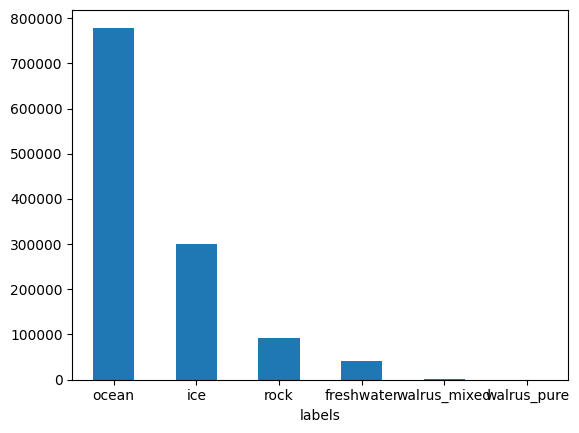

In [70]:
dataset['labels'].value_counts(sort=True).plot.bar(rot=0)

In [74]:
dataset['labels'].value_counts()

labels
ocean           779288
ice             300231
rock             92856
freshwater       40251
walrus_mixed       822
walrus_pure         48
Name: count, dtype: int64

In [75]:
dataset.to_csv('Walrus_labeled_training.csv')

In [38]:
# Ensure 'walrus_pure' and 'walrus_mixed' are in the list of classes
if 'walrus_pure' in le.classes_ and 'walrus_mixed' in le.classes_:
    walrus_pure_index = np.where(le.classes_ == 'walrus_pure')[0][0]
    walrus_mixed_index = np.where(le.classes_ == 'walrus_mixed')[0][0]
    
    walrus_pure_count = np.sum(encoded_labels == walrus_pure_index)
    walrus_mixed_count = np.sum(encoded_labels == walrus_mixed_index)
    walrus_count = max(walrus_pure_count, walrus_mixed_count)

    # Upsample 'walrus_pure' to match 'walrus_mixed'
    if walrus_pure_count < walrus_mixed_count:
        smote = SMOTE(sampling_strategy={walrus_pure_index: walrus_mixed_count}, random_state=42)
        features, encoded_labels = smote.fit_resample(features, encoded_labels)

    # Downsample other classes to match the number of 'walrus' pixels
    downsampled_features = []
    downsampled_labels = []

    walrus_pure_features = features[encoded_labels == walrus_pure_index]
    walrus_pure_labels = encoded_labels[encoded_labels == walrus_pure_index]
    walrus_mixed_features = features[encoded_labels == walrus_mixed_index]
    walrus_mixed_labels = encoded_labels[encoded_labels == walrus_mixed_index]
    
    walrus_features = np.vstack([walrus_pure_features, walrus_mixed_features])
    walrus_labels = np.hstack([walrus_pure_labels, walrus_mixed_labels])

    for class_index in np.unique(encoded_labels):
        class_features = features[encoded_labels == class_index]
        class_labels = encoded_labels[encoded_labels == class_index]
        
        if class_index in [walrus_pure_index, walrus_mixed_index]:
            downsampled_features.append(class_features)
            downsampled_labels.append(class_labels)
        else:
            downsampled_class_features, downsampled_class_labels = resample(
                class_features, class_labels, 
                replace=False, 
                n_samples=walrus_count, 
                random_state=42
            )
            downsampled_features.append(downsampled_class_features)
            downsampled_labels.append(downsampled_class_labels)

    features = np.vstack([walrus_features] + downsampled_features)
    encoded_labels = np.hstack([walrus_labels] + downsampled_labels)
else:
    print("'walrus_pure' or 'walrus_mixed' class not found in the labels. Please check your data.")
    # Handle the case where 'walrus_pure' or 'walrus_mixed' class is not found, e.g., error or proceed without downsampling
    raise ValueError("'walrus_pure' or 'walrus_mixed' class not found in the labels. Please check your data.")


In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
# Save the model
model_filename = "RF_allislands_SMOTE_updownsamp.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.88      0.89      0.88       157
         ice       0.90      0.85      0.88       157
       ocean       0.99      0.98      0.98       165
        rock       0.95      0.87      0.91       144
walrus_mixed       0.92      0.98      0.95       344
 walrus_pure       1.00      1.00      1.00       349

    accuracy                           0.95      1316
   macro avg       0.94      0.93      0.93      1316
weighted avg       0.95      0.95      0.95      1316


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


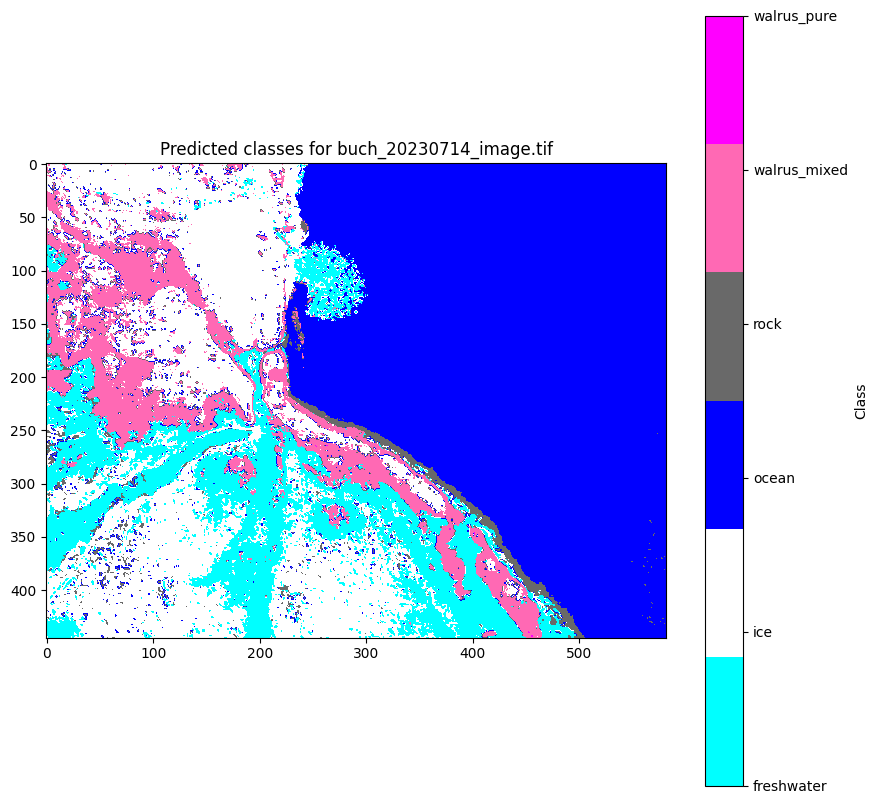

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


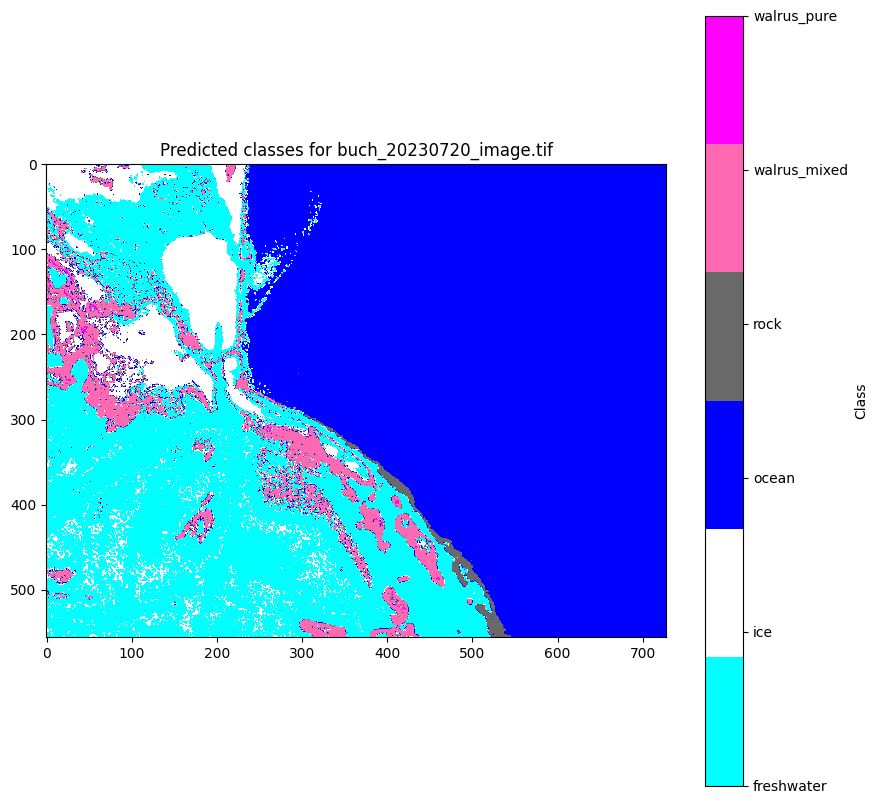

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


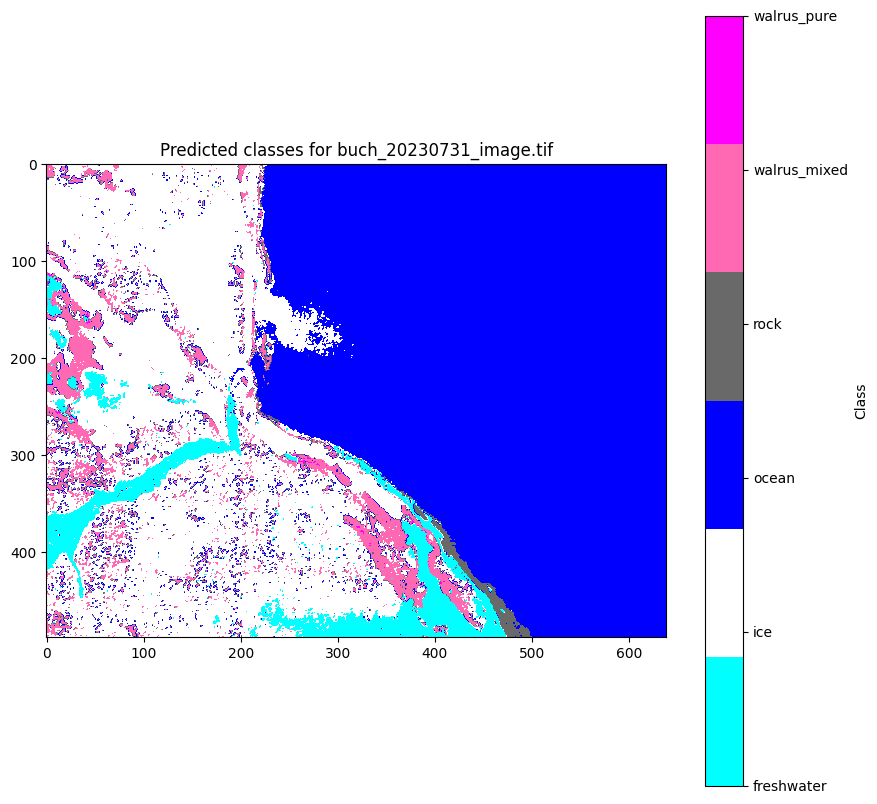

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_pure']


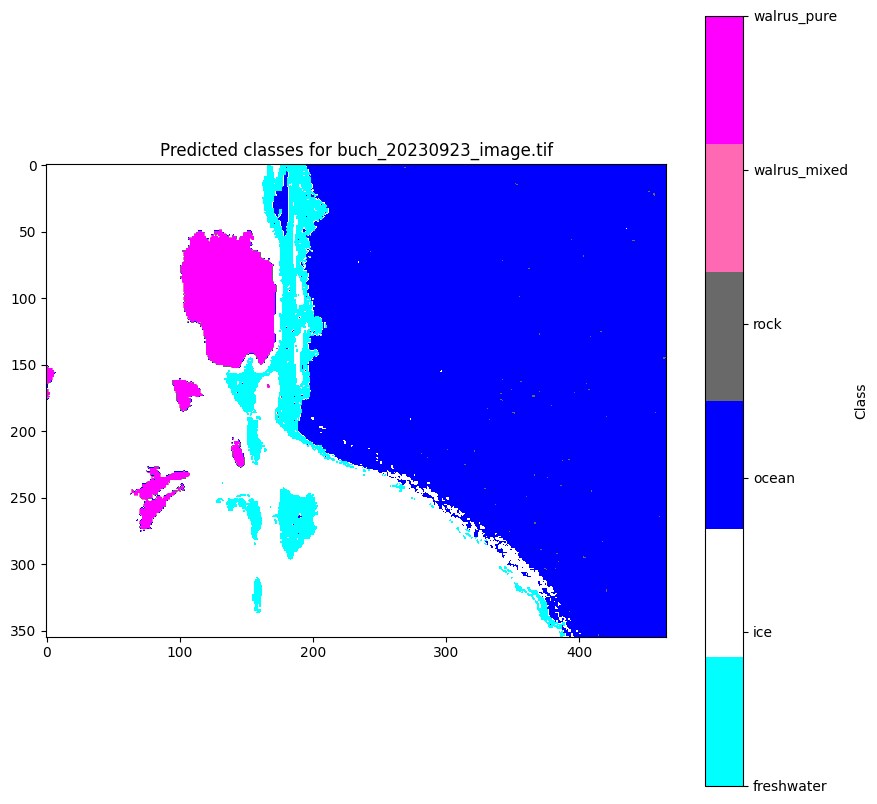

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


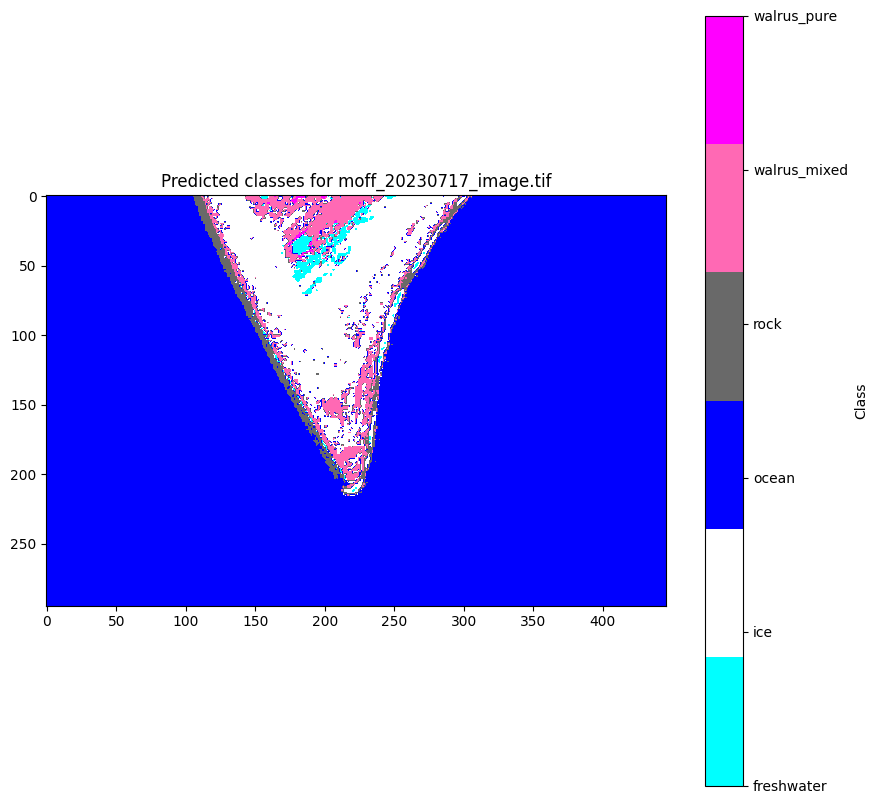

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


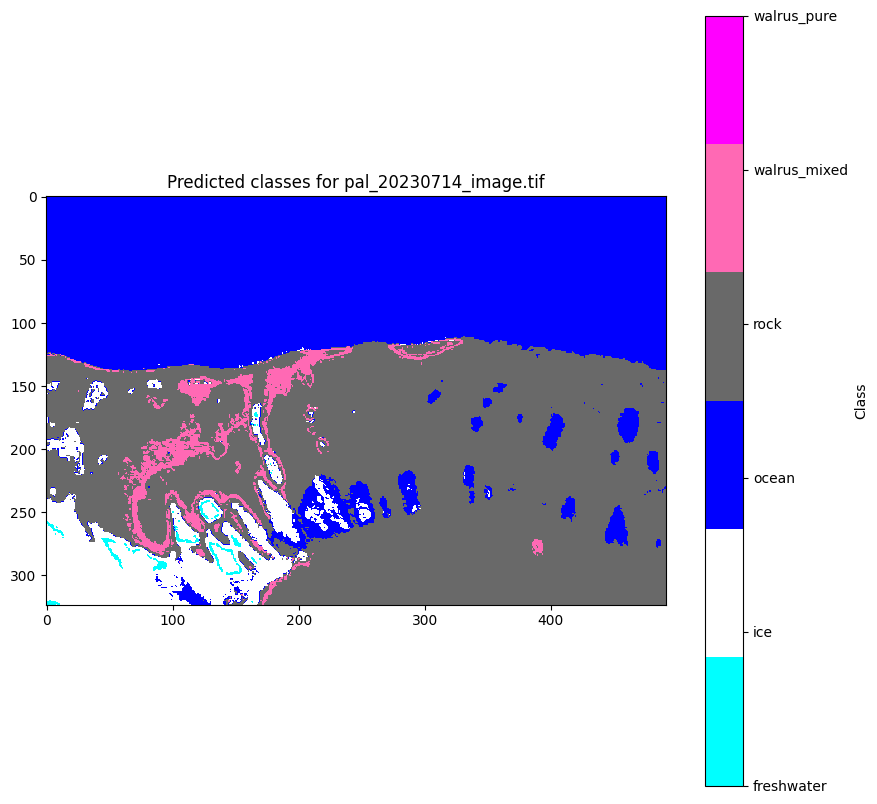

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


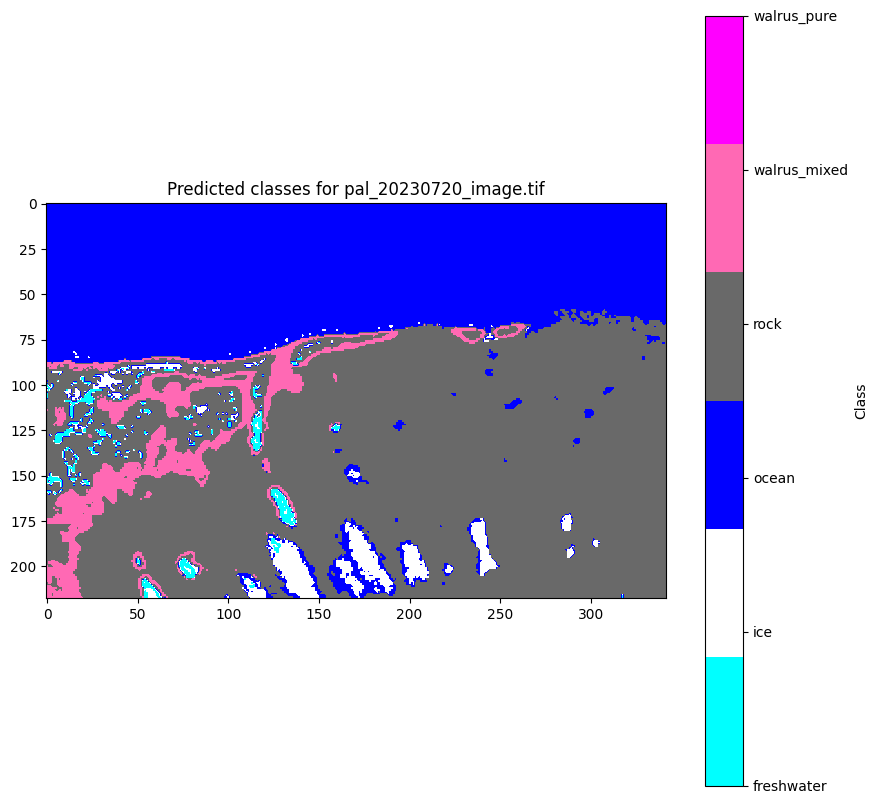

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


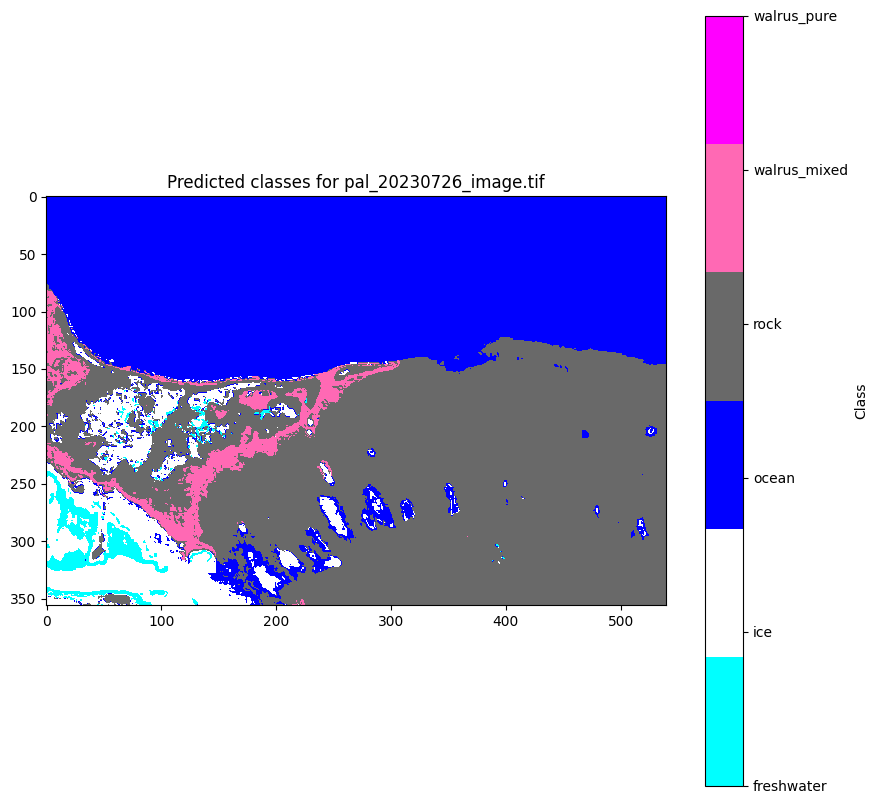

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


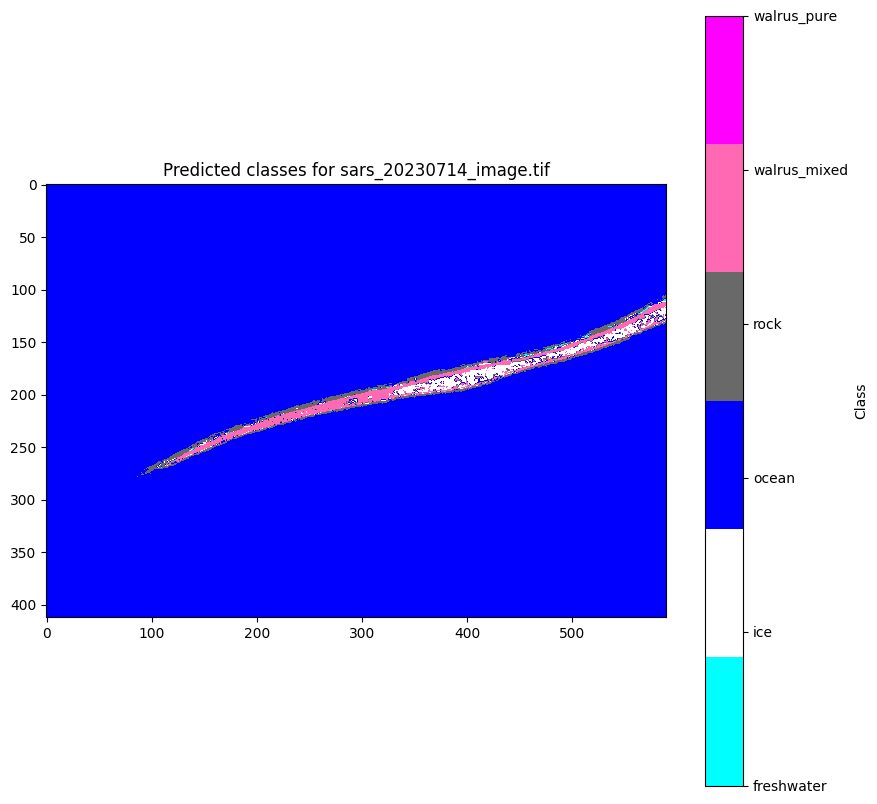

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


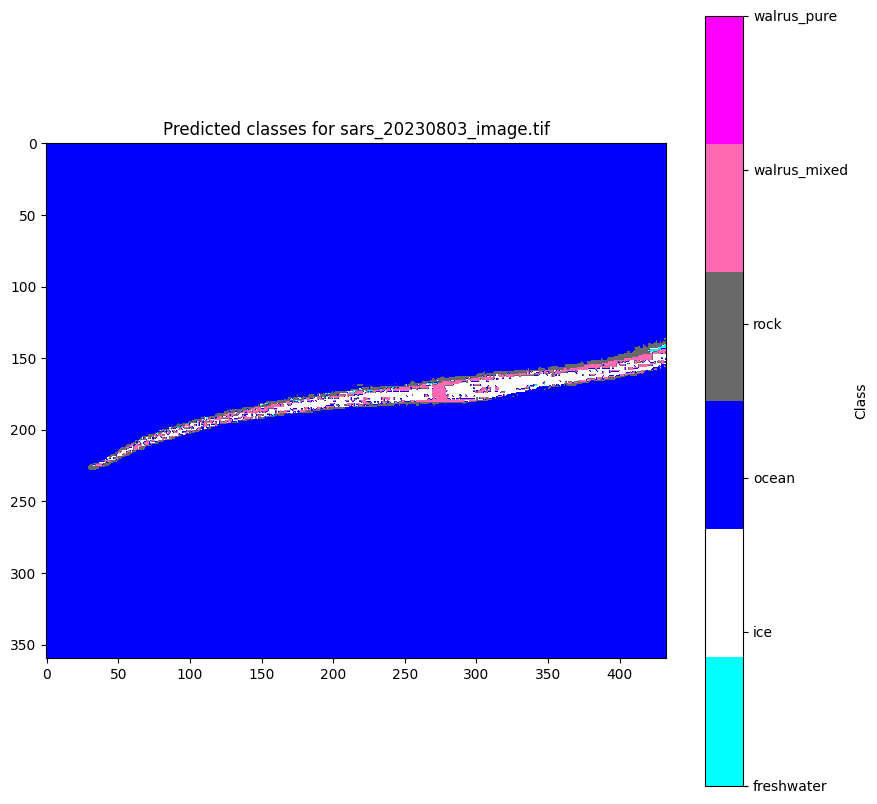

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


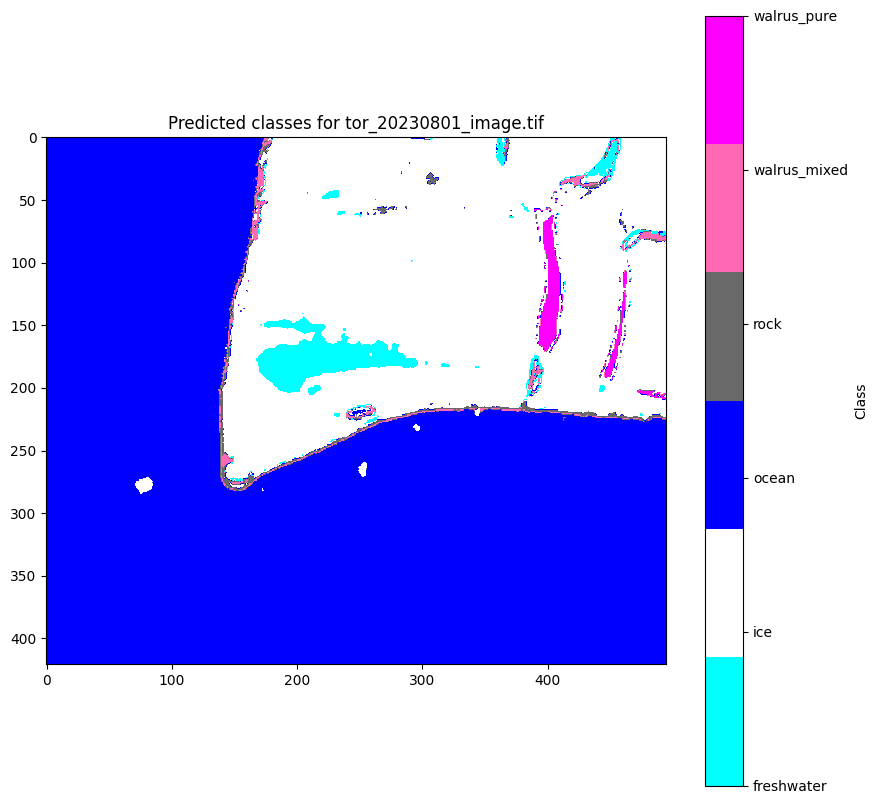

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


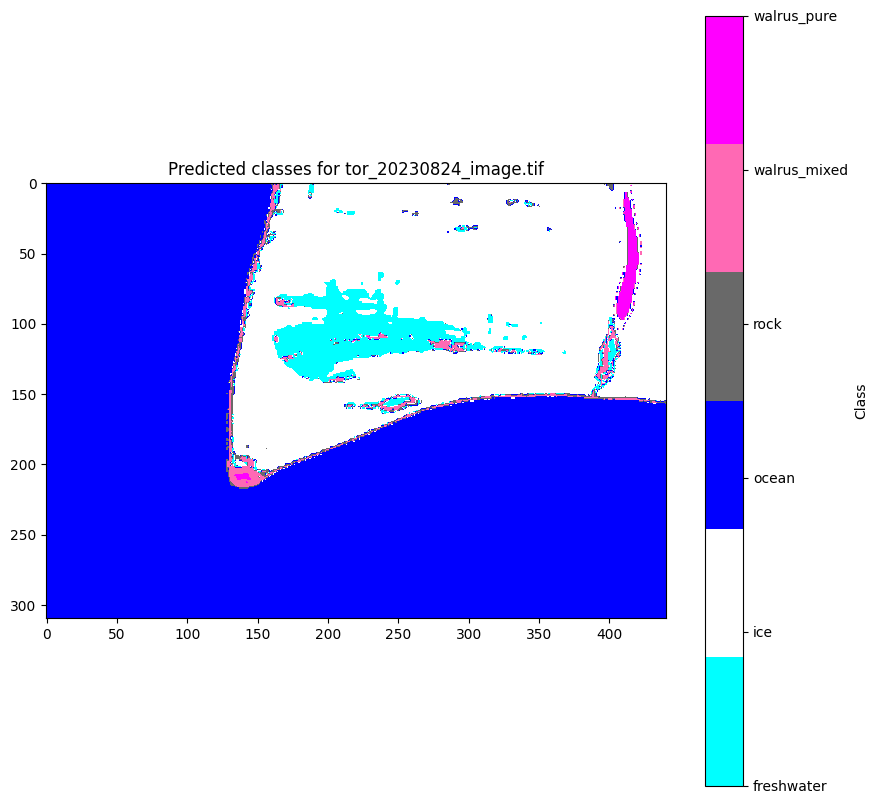

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


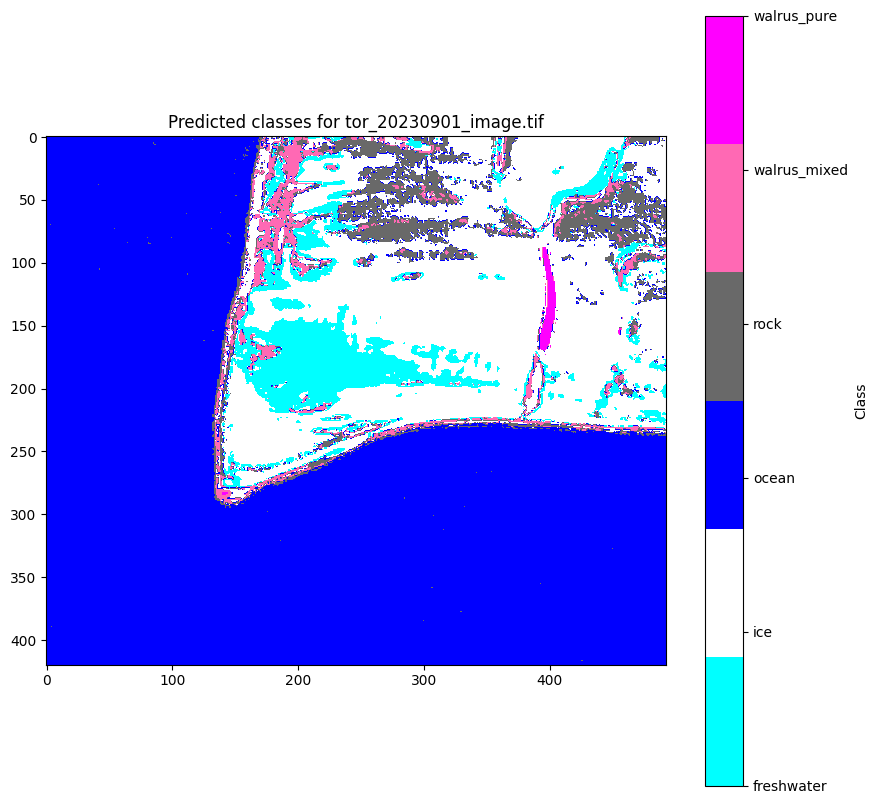

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


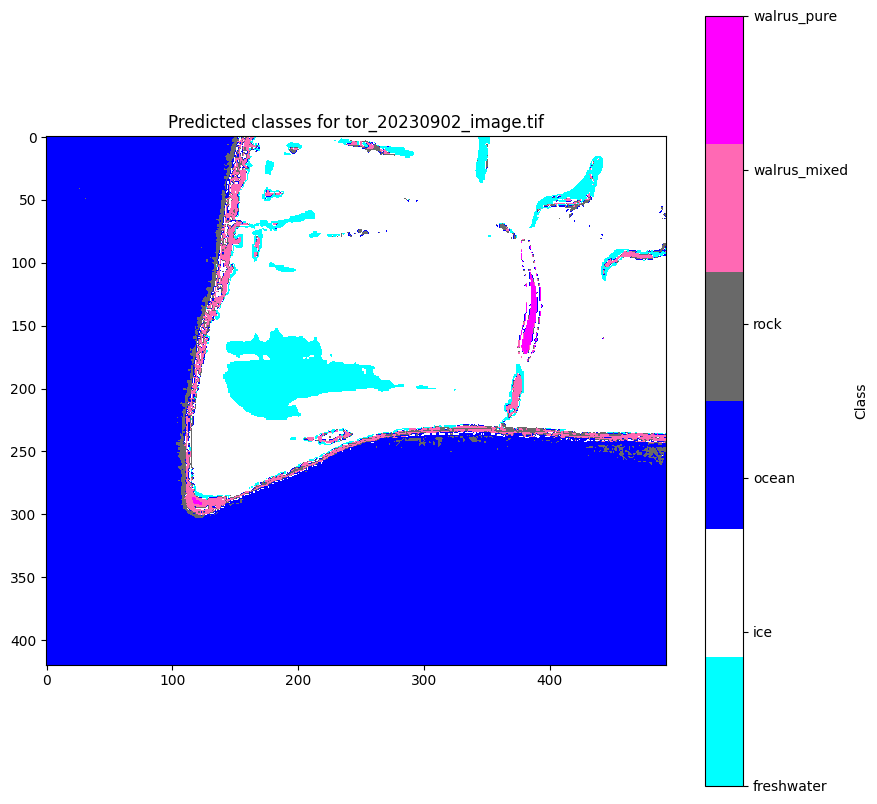

In [42]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [43]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from RF_allislands_SMOTE_updownsamp.joblib


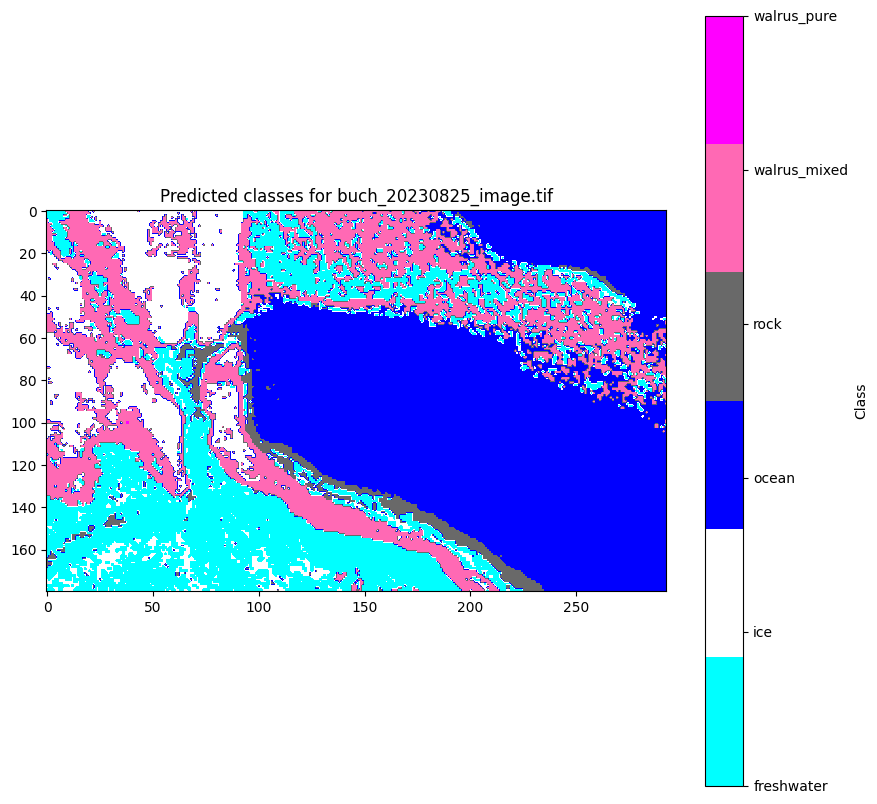

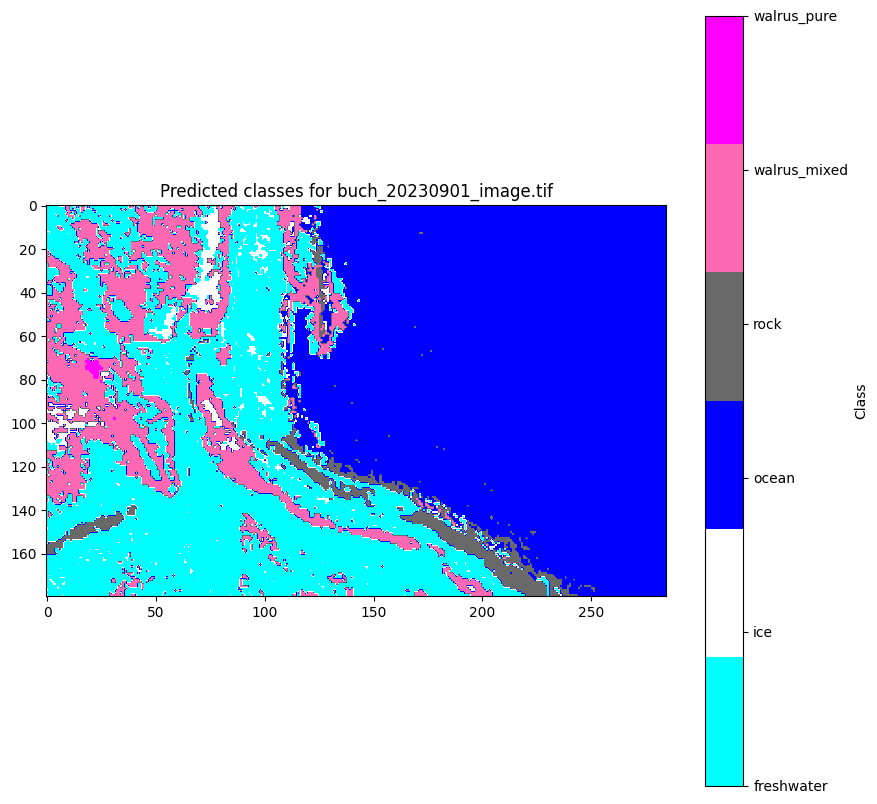

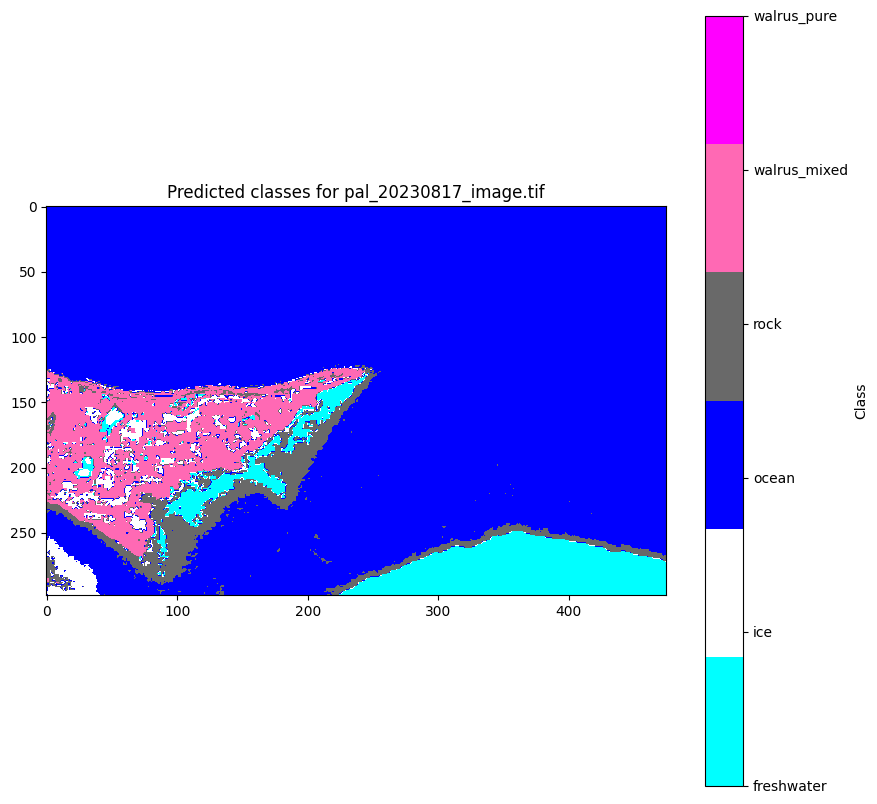

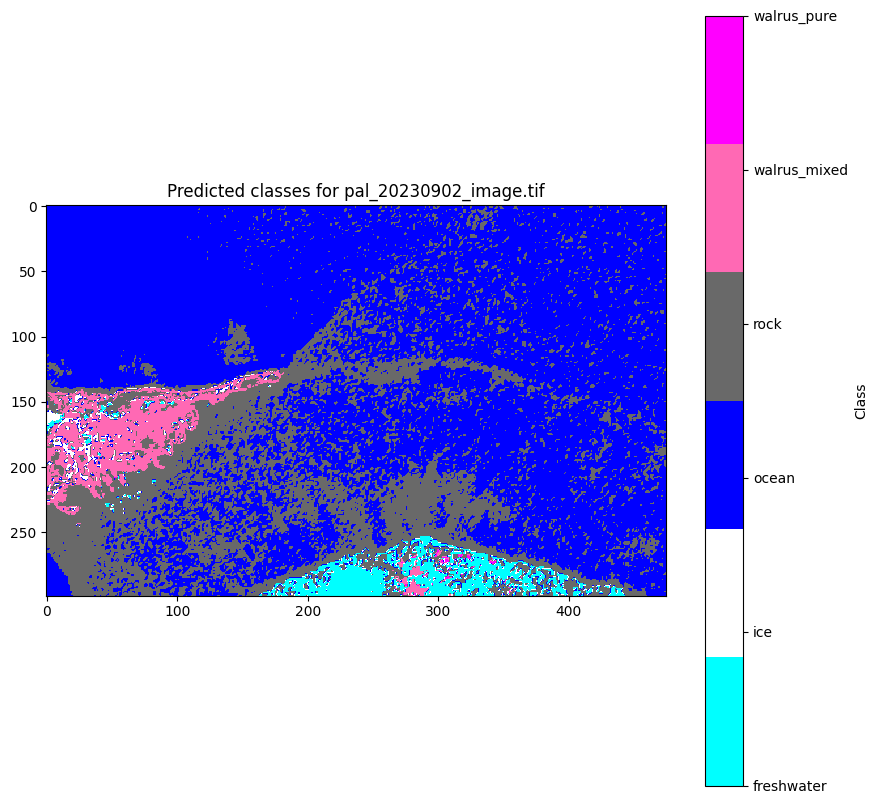

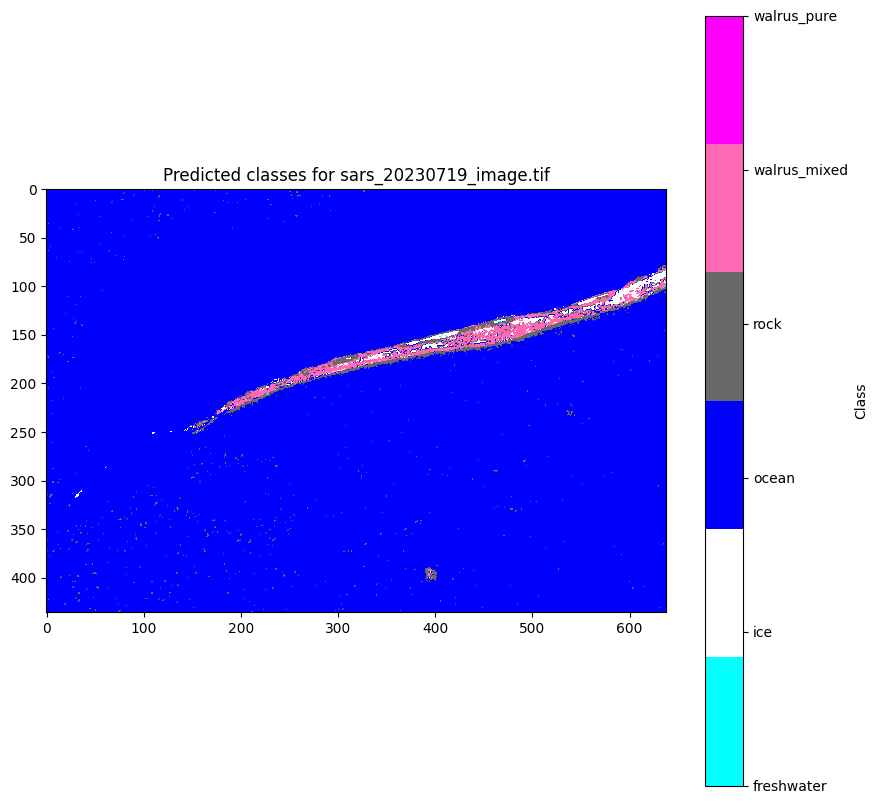

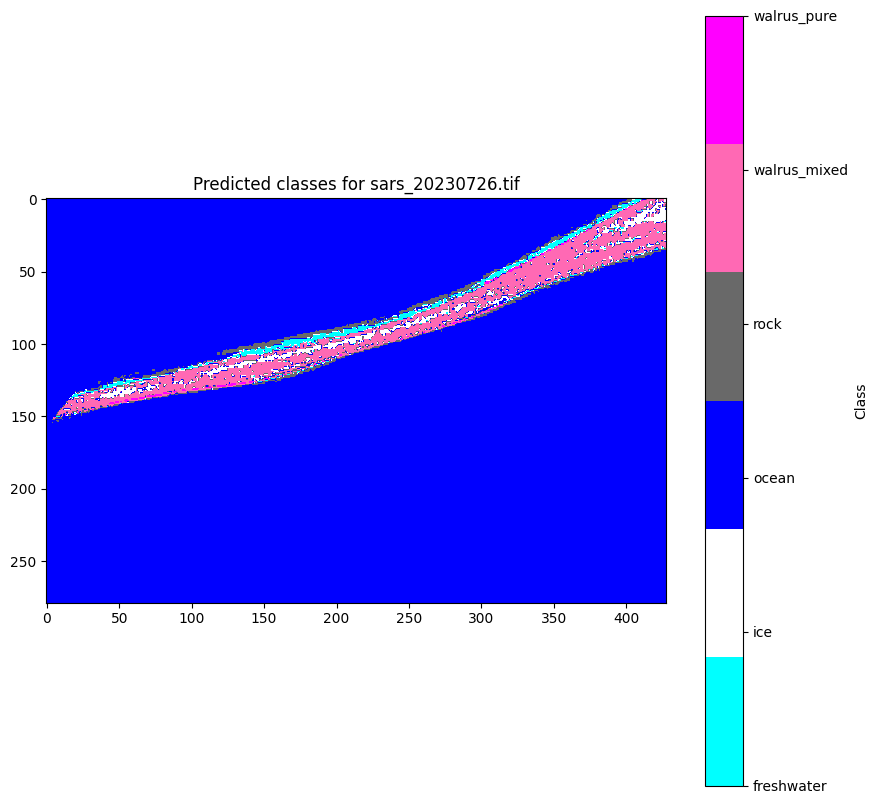

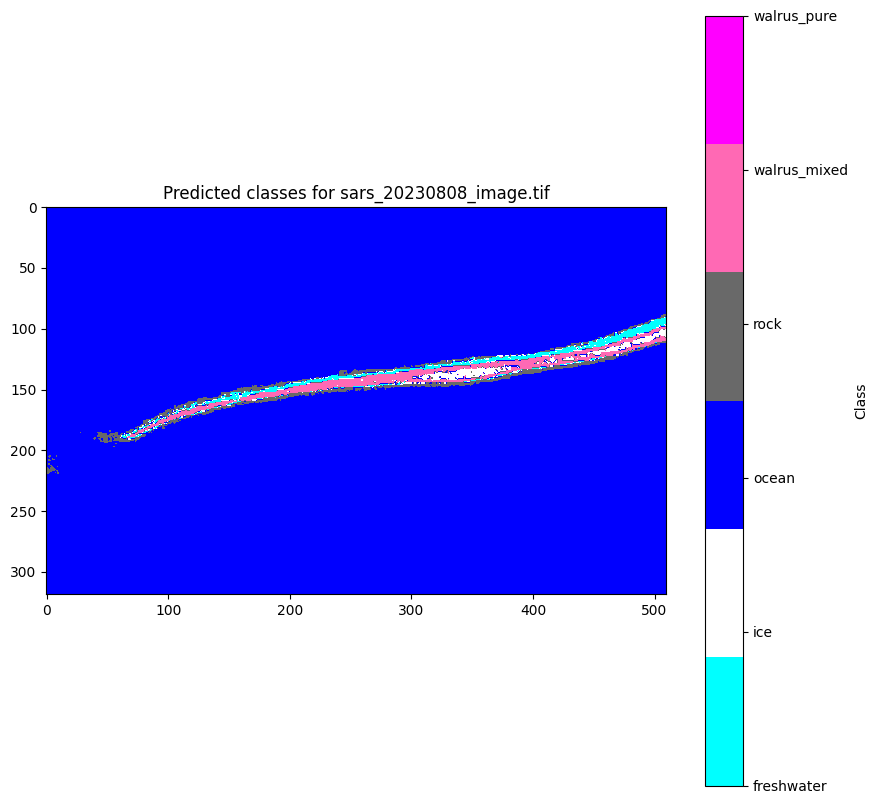

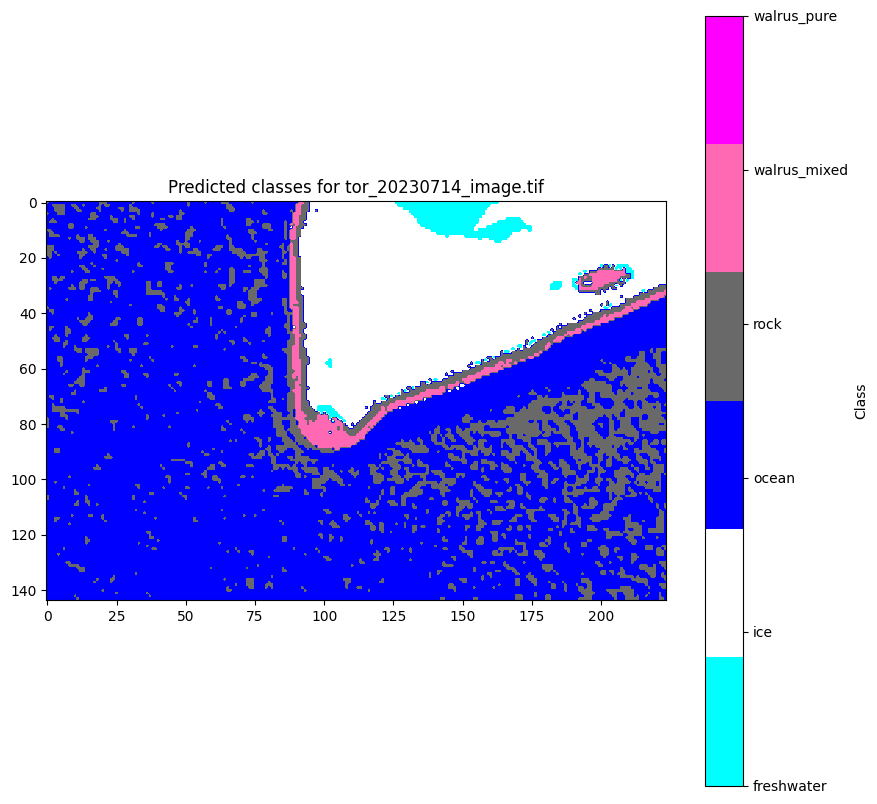

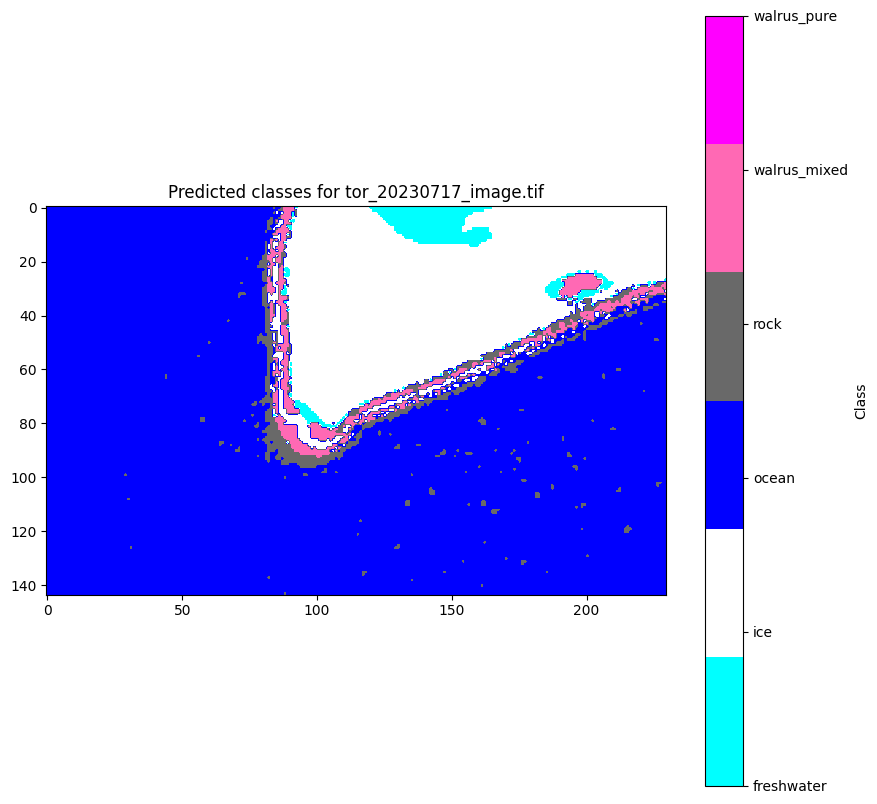

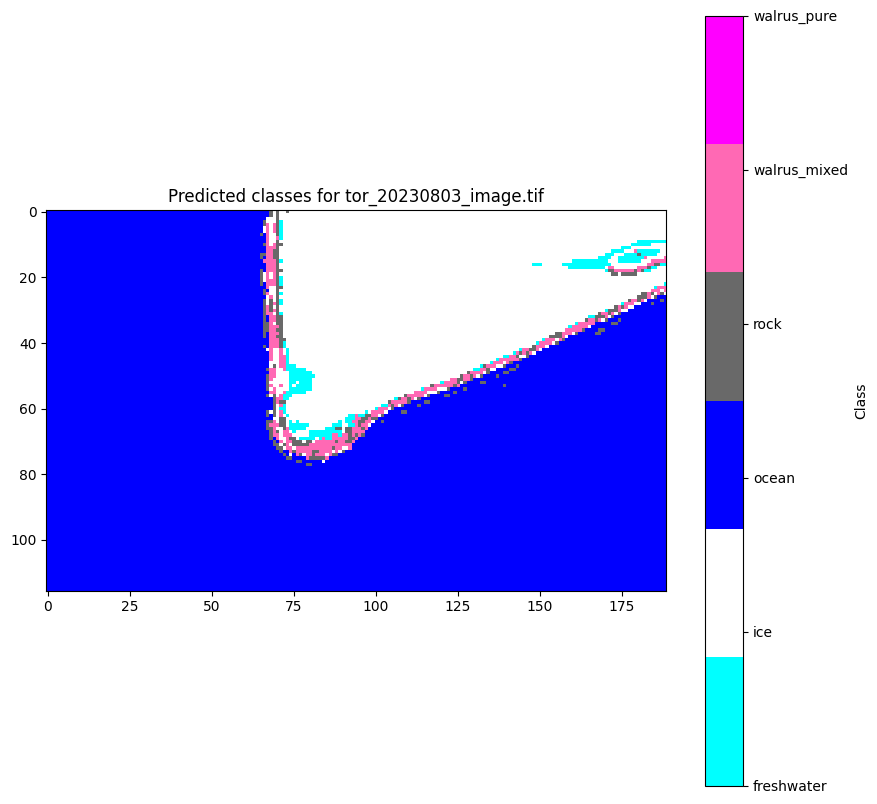

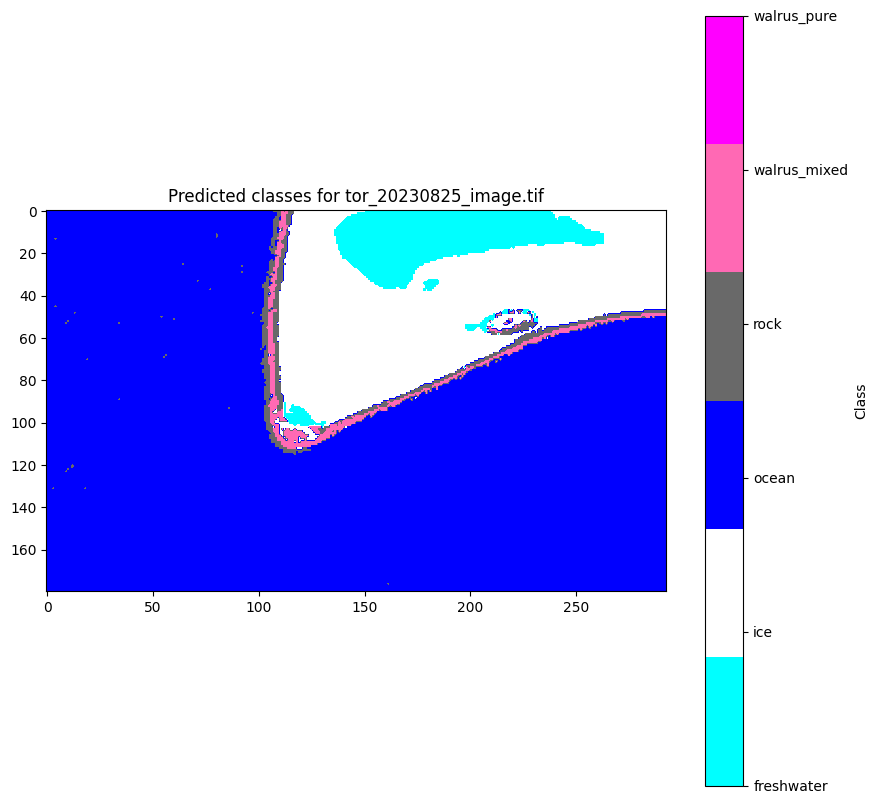

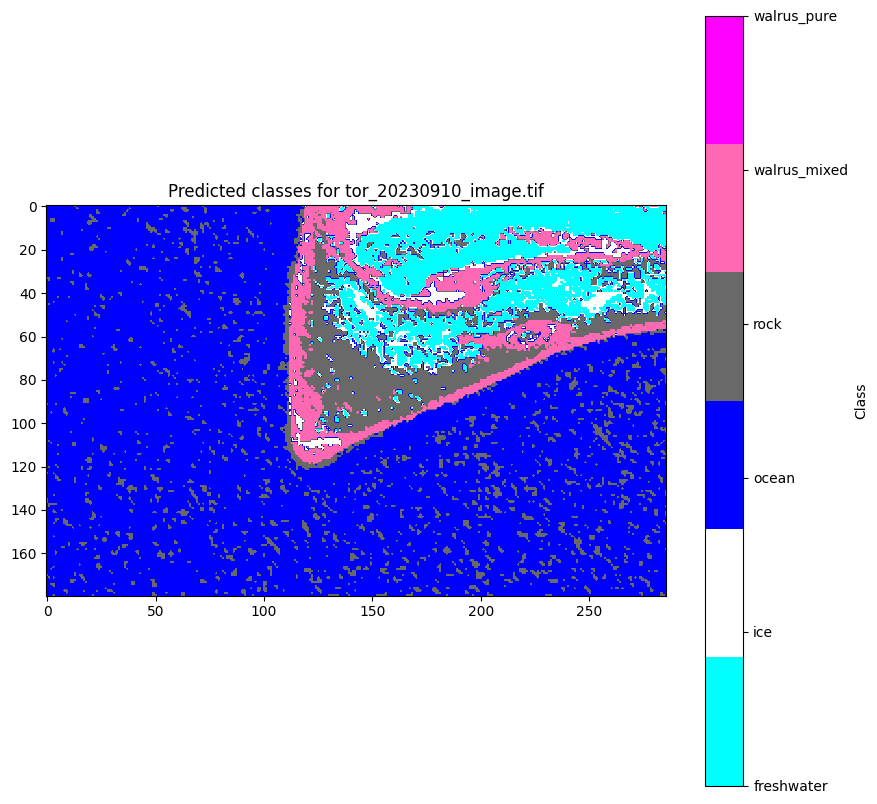

In [44]:
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()


In [8]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib
from sklearn.utils import resample

In [9]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"  

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

In [10]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [11]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [12]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)


In [13]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)


Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\moff_20230717_train.shp
Image: C:\Users\Student\D

In [14]:
features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [16]:
# Ensure 'walrus_pure' and 'walrus_mixed' are in the list of classes
if 'walrus_pure' in le.classes_ and 'walrus_mixed' in le.classes_:
    walrus_pure_index = np.where(le.classes_ == 'walrus_pure')[0][0]
    walrus_mixed_index = np.where(le.classes_ == 'walrus_mixed')[0][0]
    
    walrus_count = np.sum(encoded_labels == walrus_pure_index) + np.sum(encoded_labels == walrus_mixed_index)

    # Downsample other classes to match the number of 'walrus' pixels
    downsampled_features = []
    downsampled_labels = []

    for class_index in np.unique(encoded_labels):
        class_features = features[encoded_labels == class_index]
        class_labels = encoded_labels[encoded_labels == class_index]
        
        if class_index in [walrus_pure_index, walrus_mixed_index]:
            downsampled_features.append(class_features)
            downsampled_labels.append(class_labels)
        else:
            downsampled_class_features, downsampled_class_labels = resample(
                class_features, class_labels, 
                replace=False, 
                n_samples=walrus_count, 
                random_state=42
            )
            downsampled_features.append(downsampled_class_features)
            downsampled_labels.append(downsampled_class_labels)

    features = np.vstack(downsampled_features)
    encoded_labels = np.hstack(downsampled_labels)
else:
    print("'walrus_pure' or 'walrus_mixed' class not found in the labels. Please check your data.")
    # Handle the case where 'walrus_pure' or 'walrus_mixed' class is not found, e.g., raise an error or proceed without downsampling
    raise ValueError("'walrus_pure' or 'walrus_mixed' class not found in the labels. Please check your data.")


In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [18]:
# Save the model
model_filename = "allislands_RF_randomdownsamp.joblib"
joblib.dump(model, model_filename)


['allislands_RF_randomdownsamp.joblib']

In [19]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

  freshwater       0.88      0.89      0.89       196
         ice       0.92      0.86      0.89       184
       ocean       0.98      0.98      0.98       159
        rock       0.93      0.90      0.92       158
walrus_mixed       0.84      0.94      0.89       164
 walrus_pure       0.83      0.56      0.67         9

    accuracy                           0.91       870
   macro avg       0.90      0.85      0.87       870
weighted avg       0.91      0.91      0.91       870


In [20]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


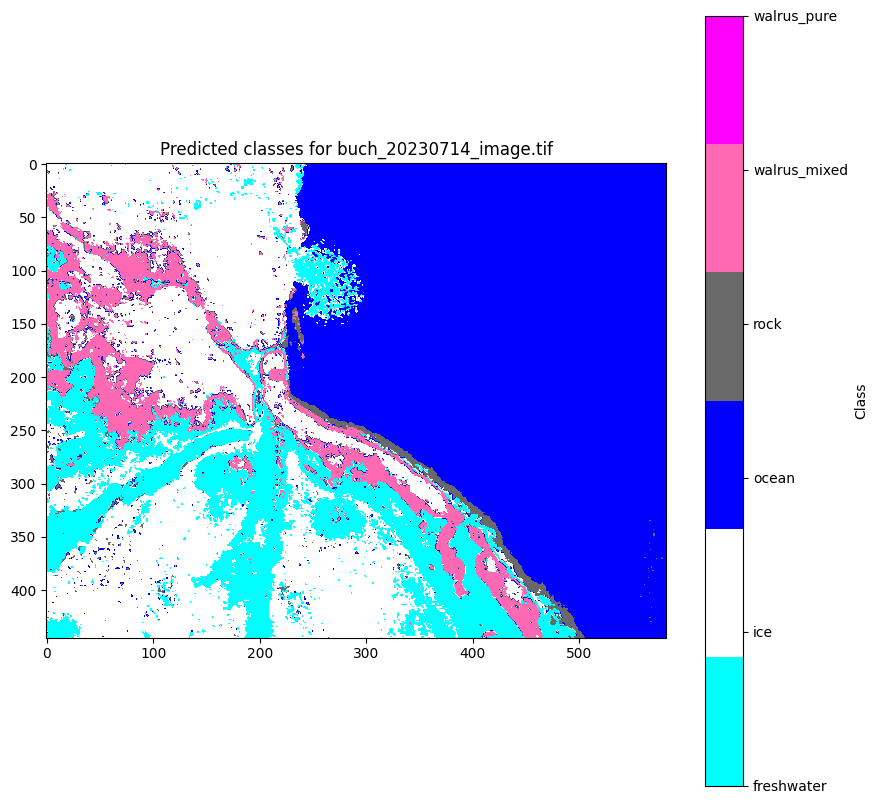

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


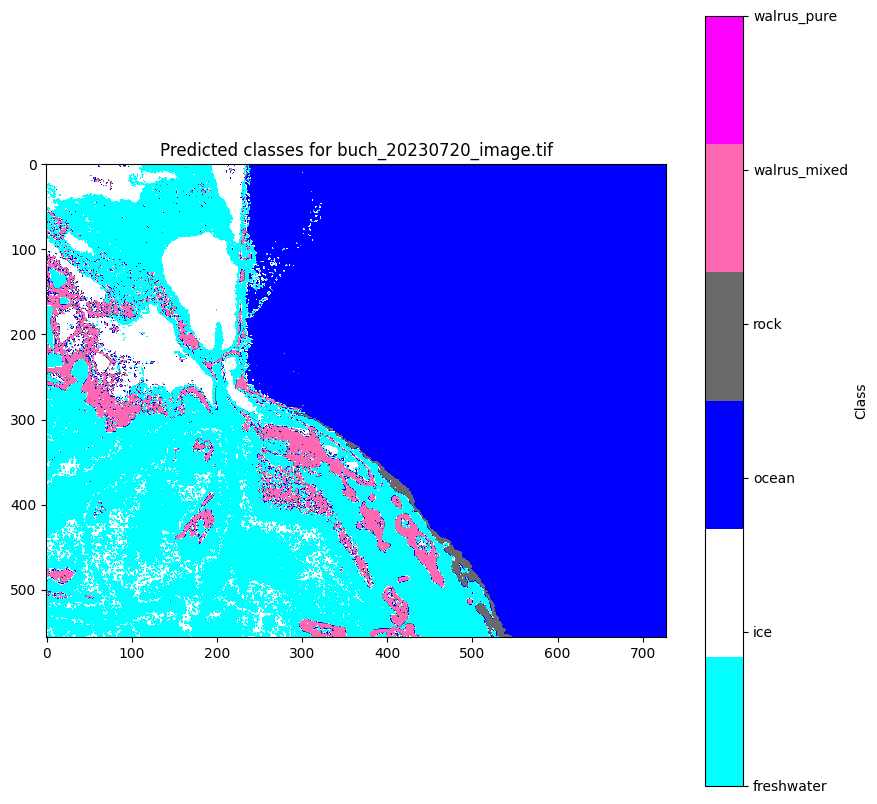

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


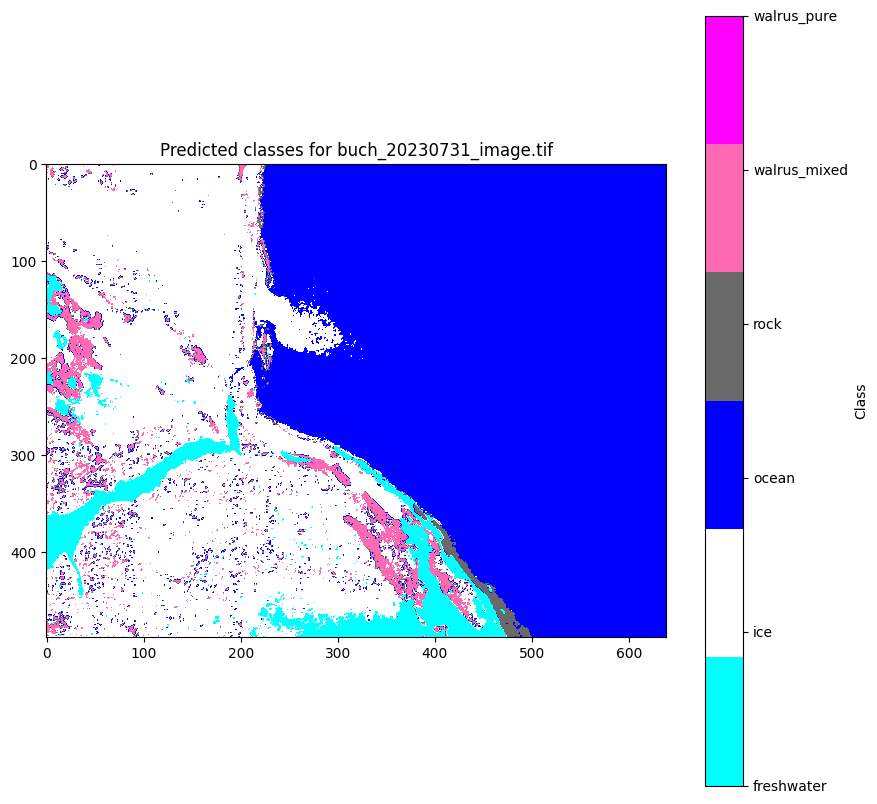

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


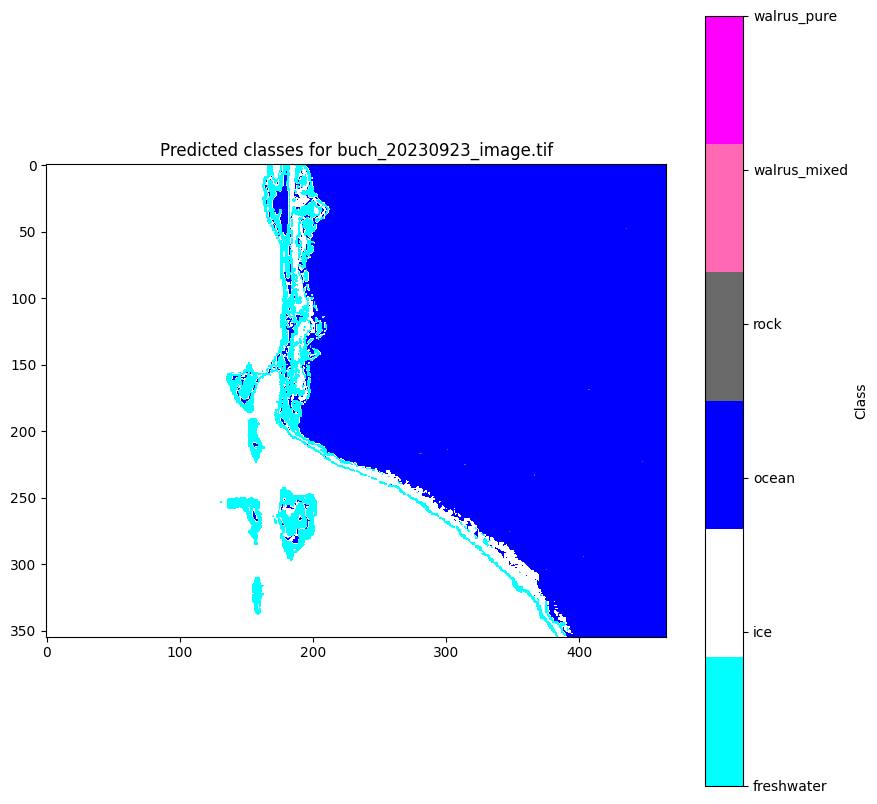

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


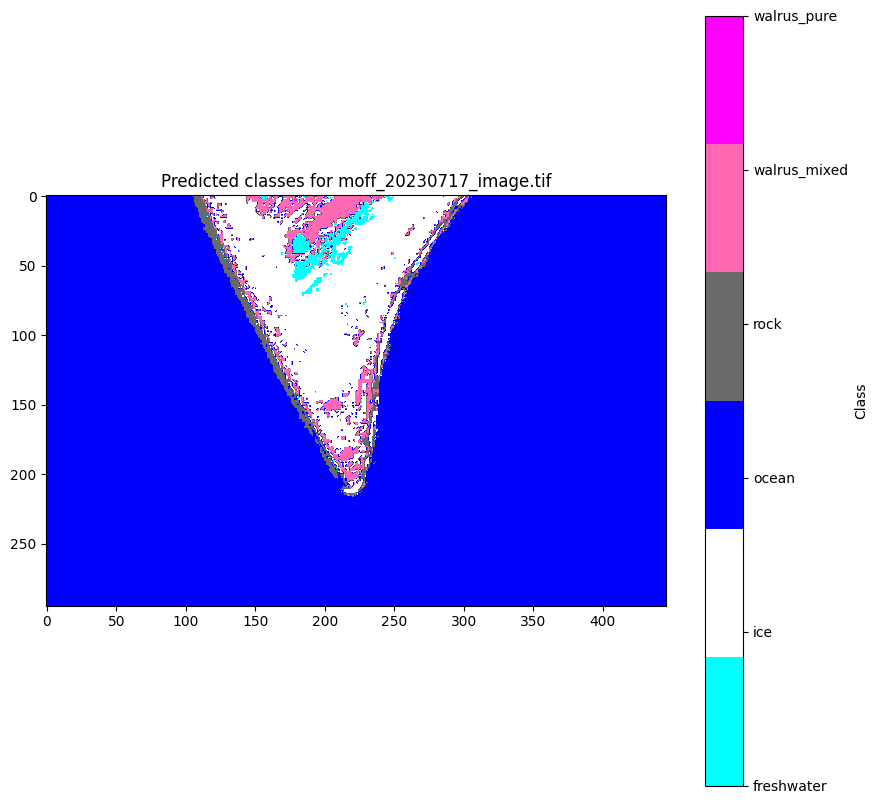

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


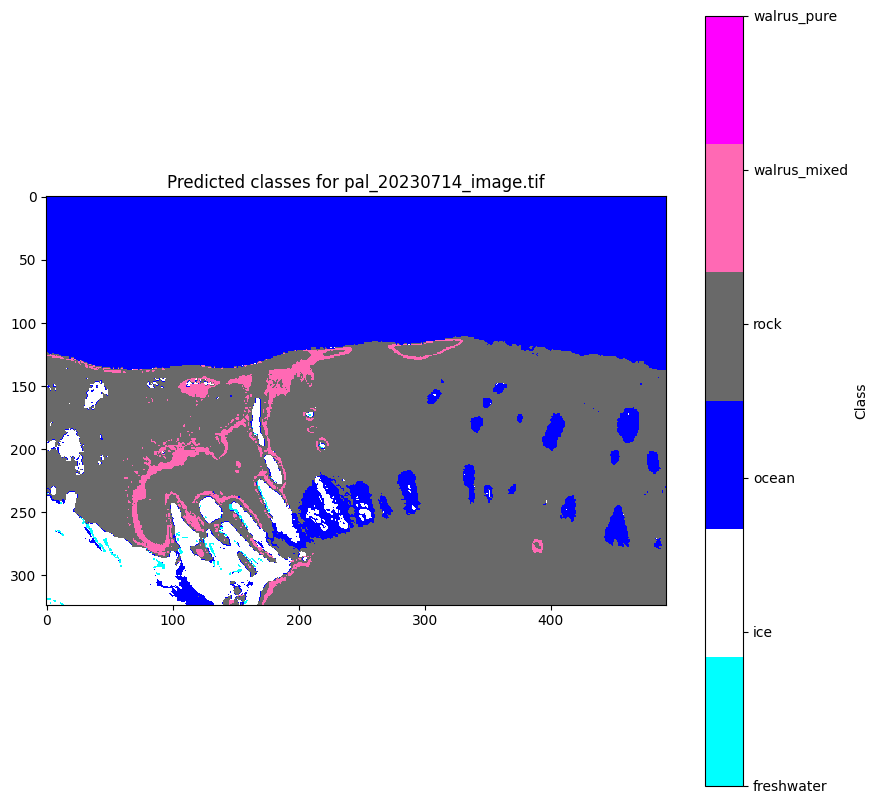

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


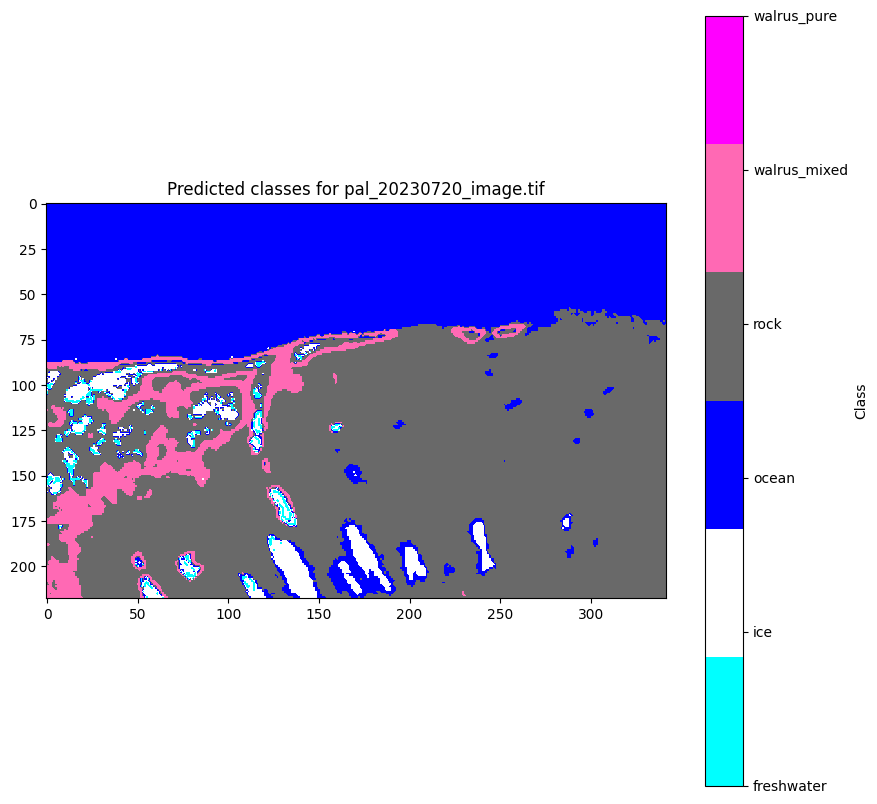

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


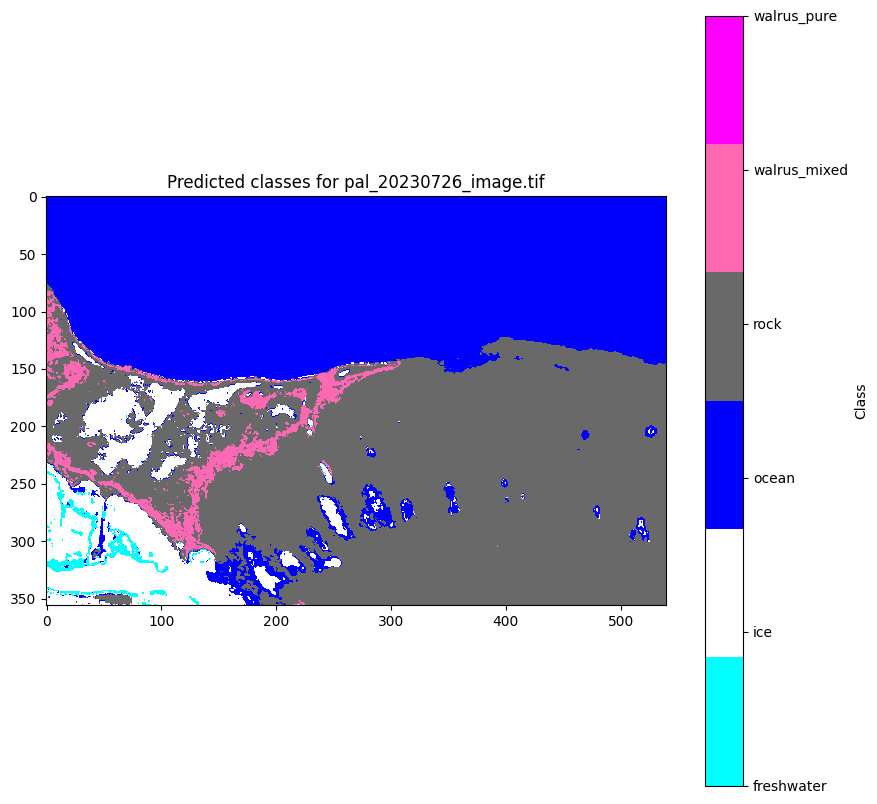

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


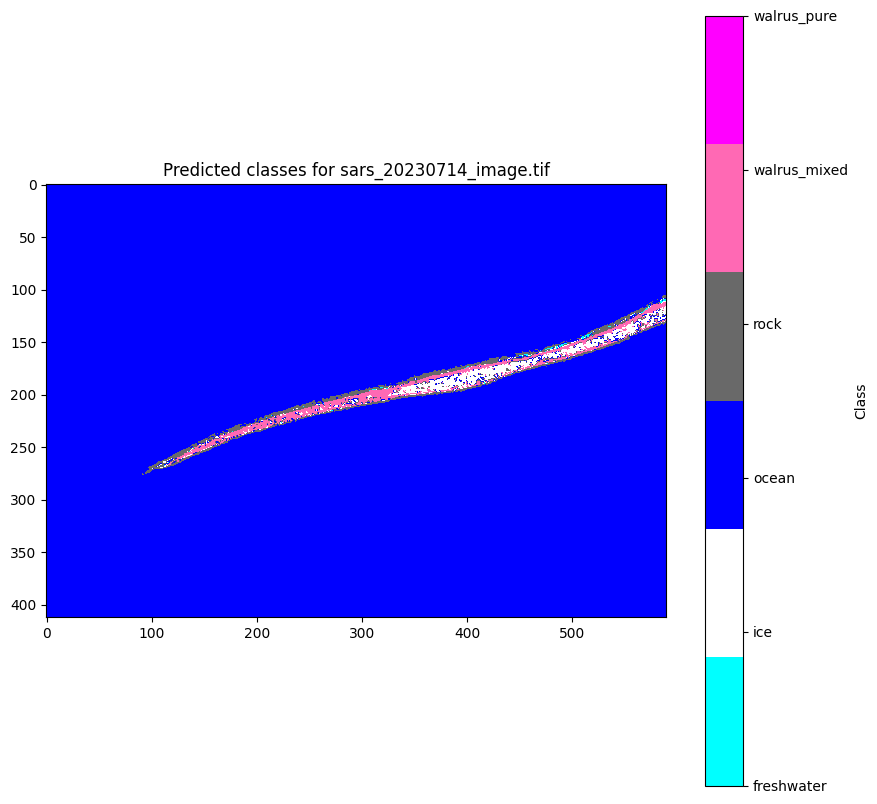

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


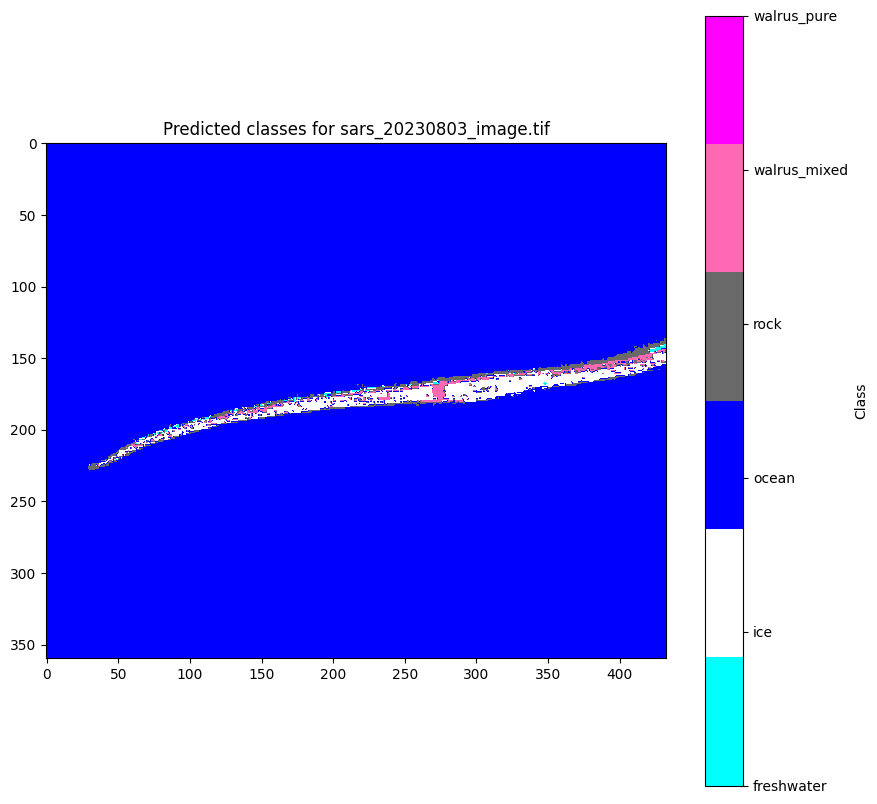

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


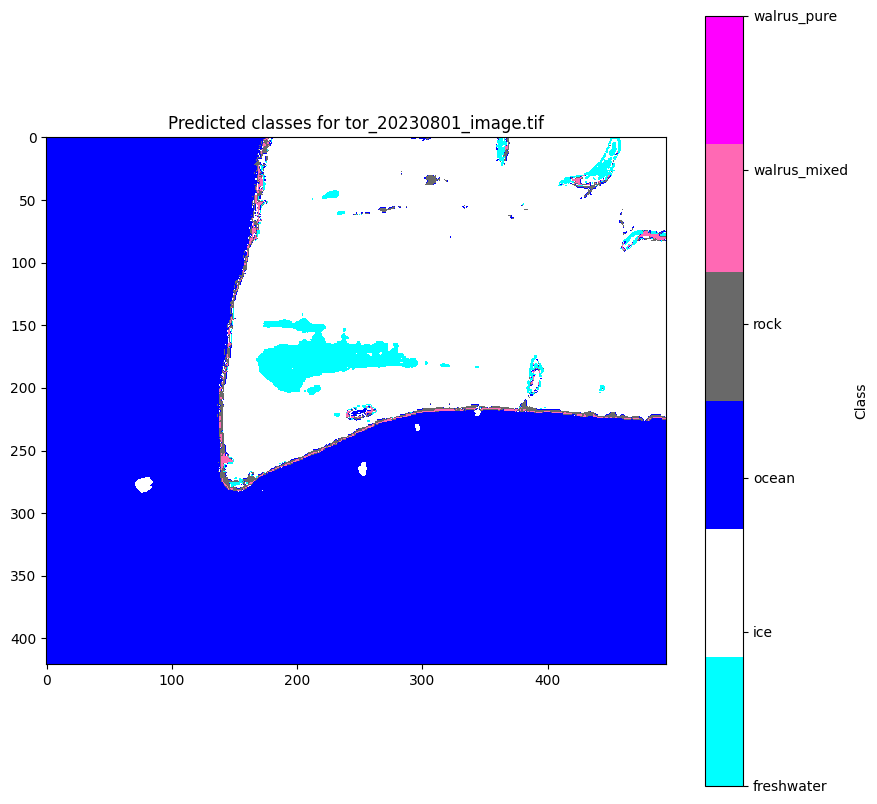

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


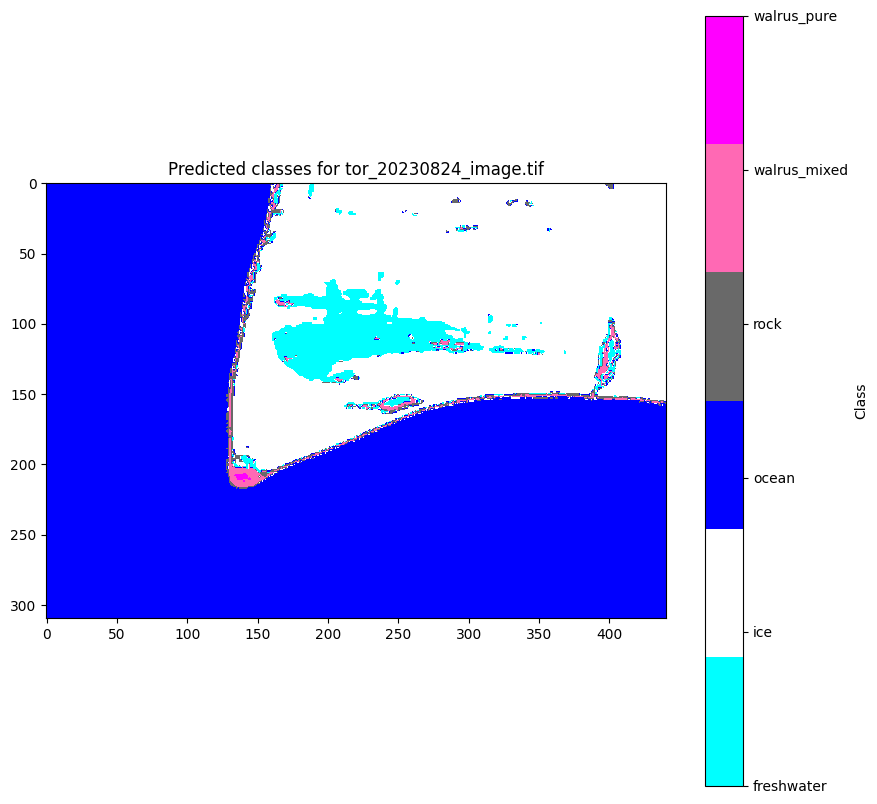

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


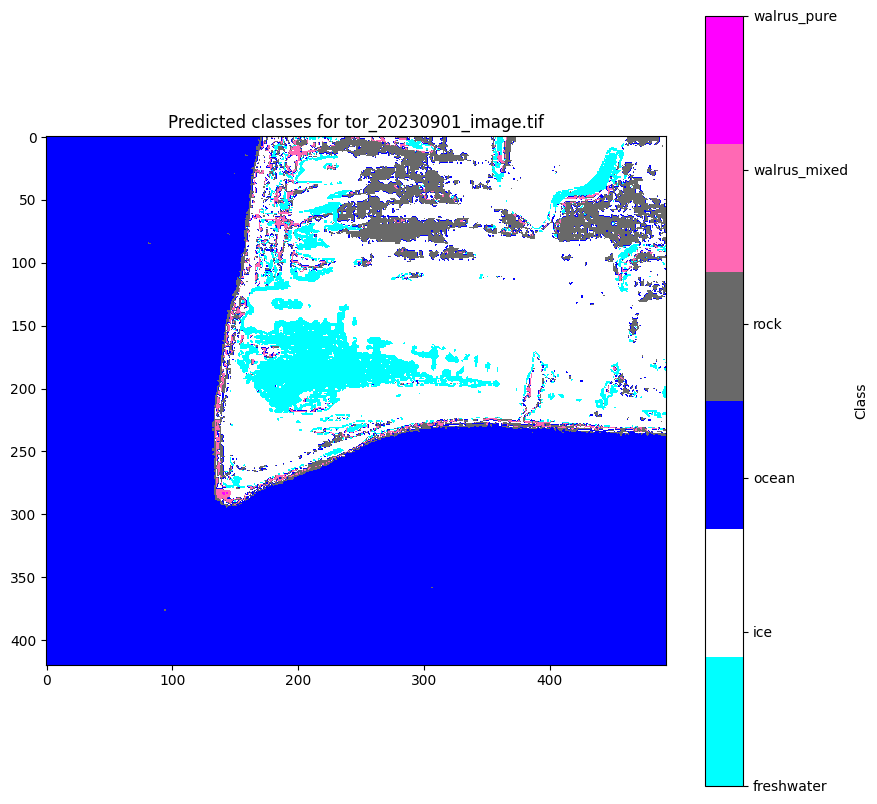

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


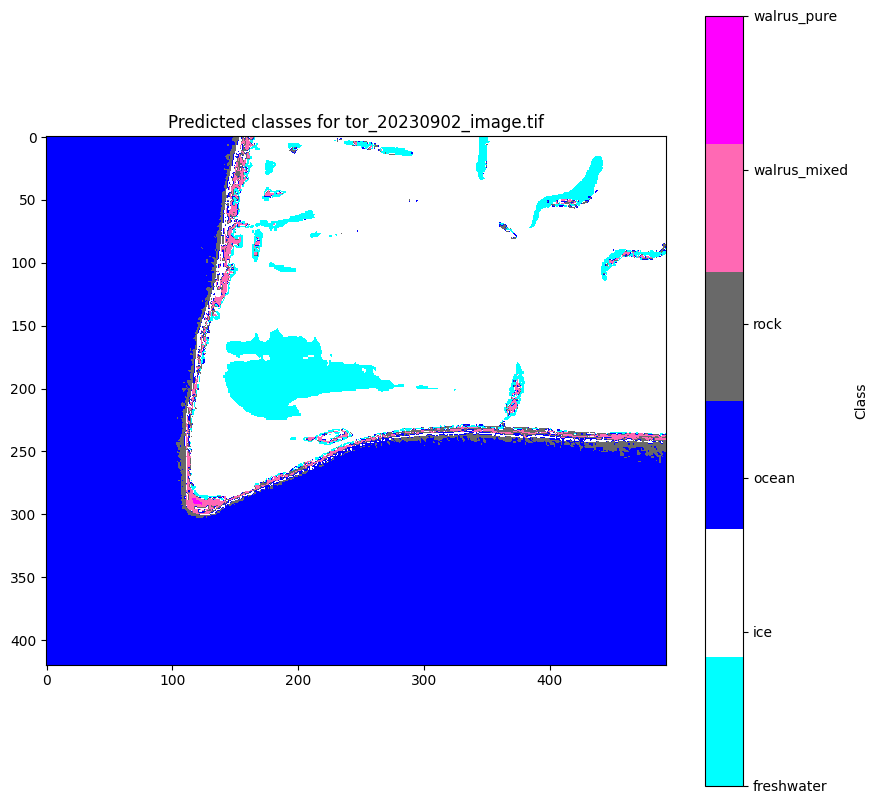

In [21]:
# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [22]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")


Model loaded from allislands_RF_randomdownsamp.joblib


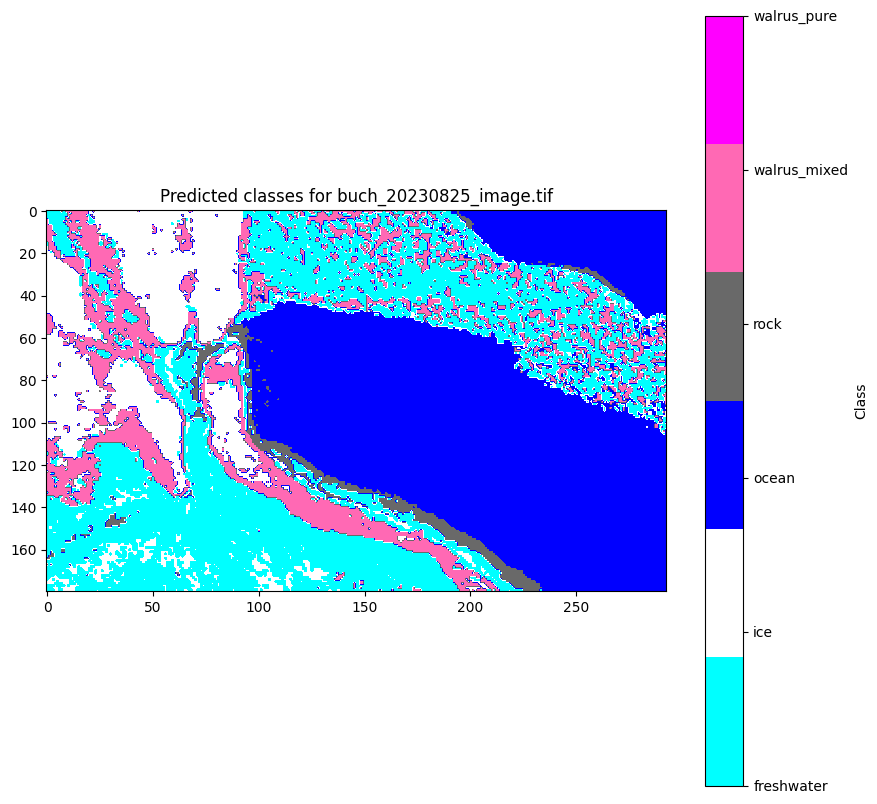

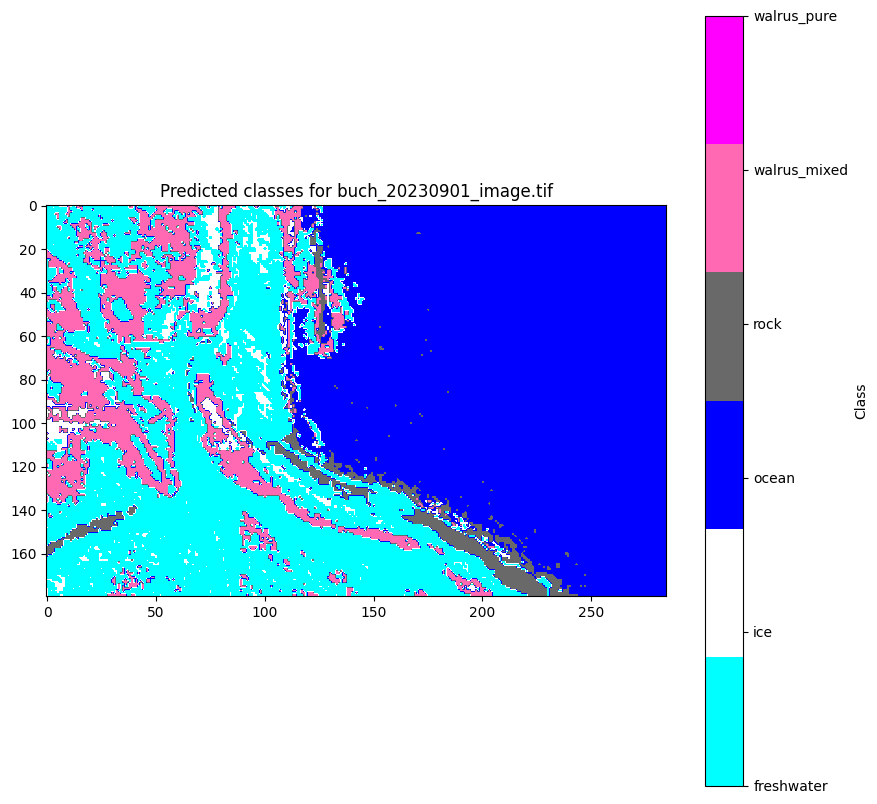

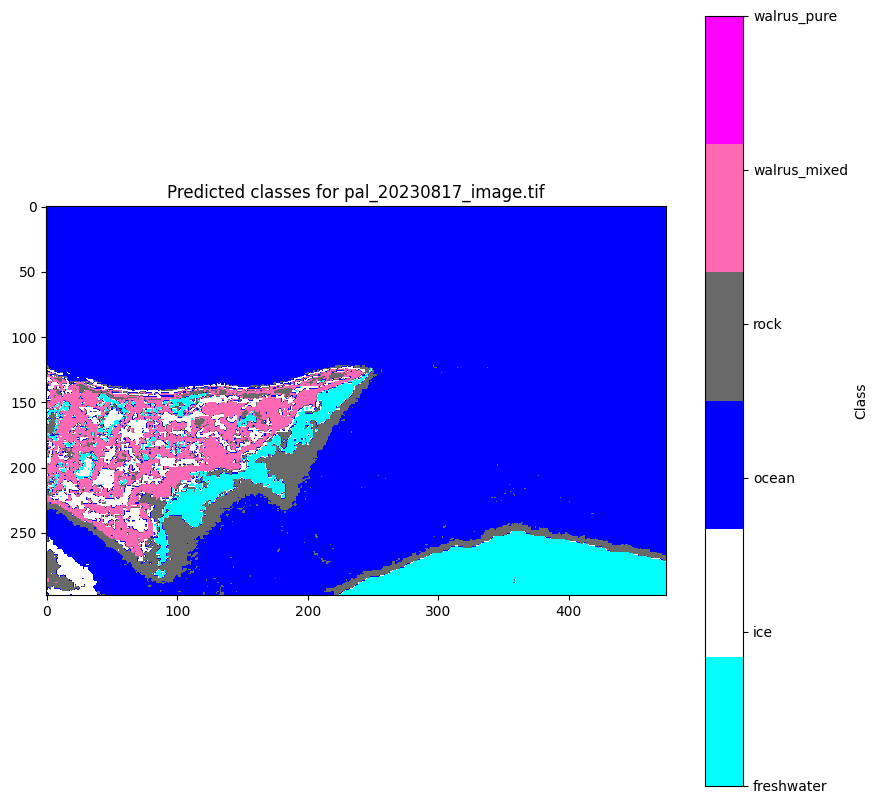

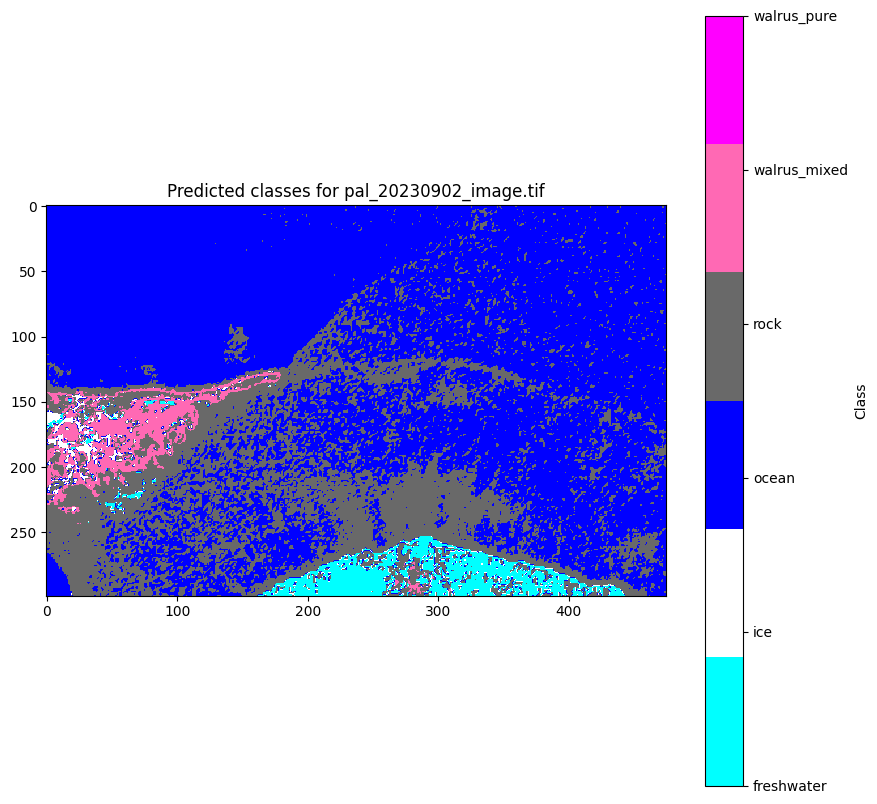

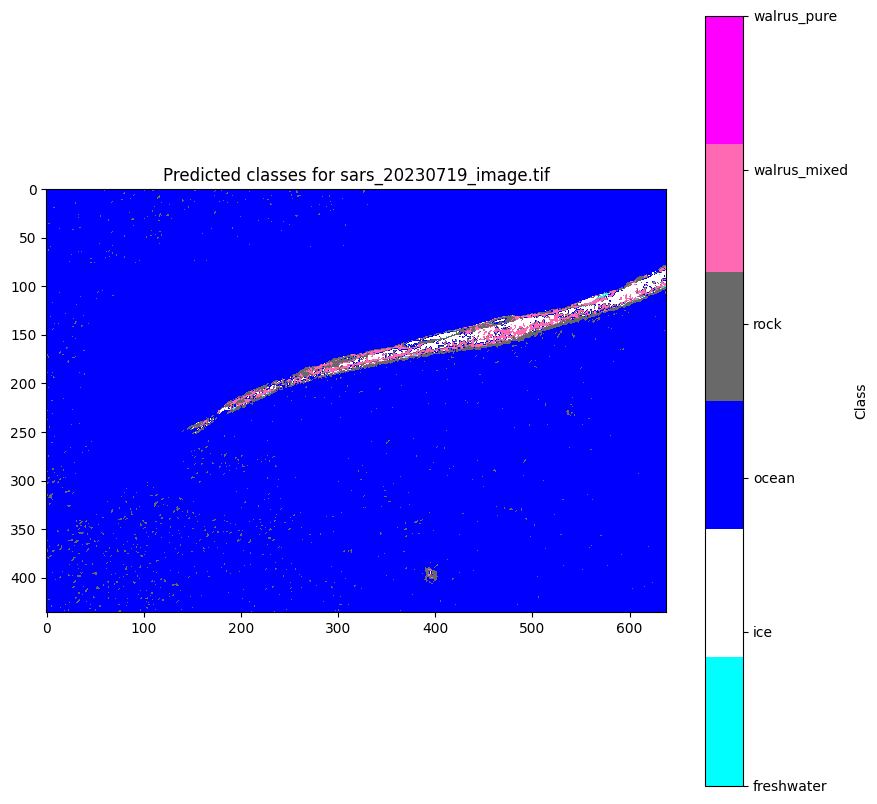

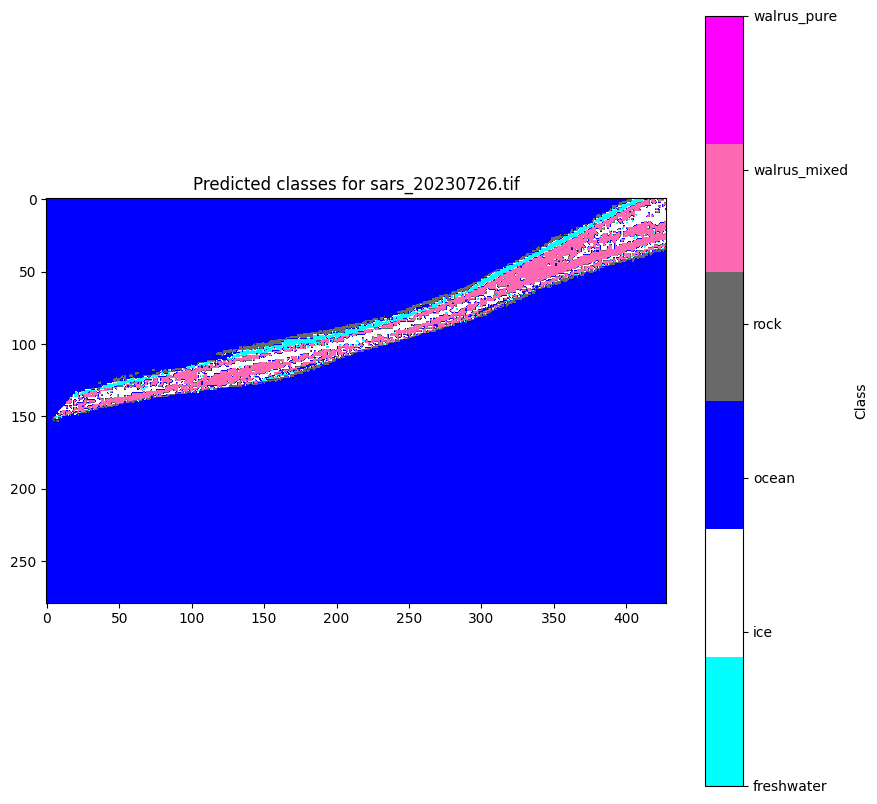

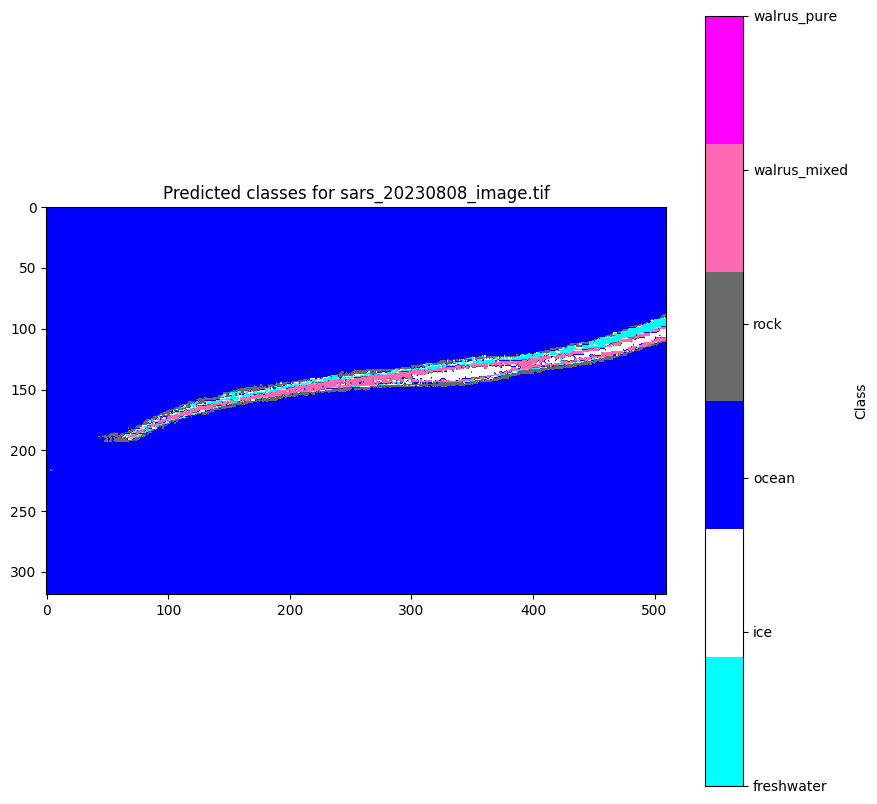

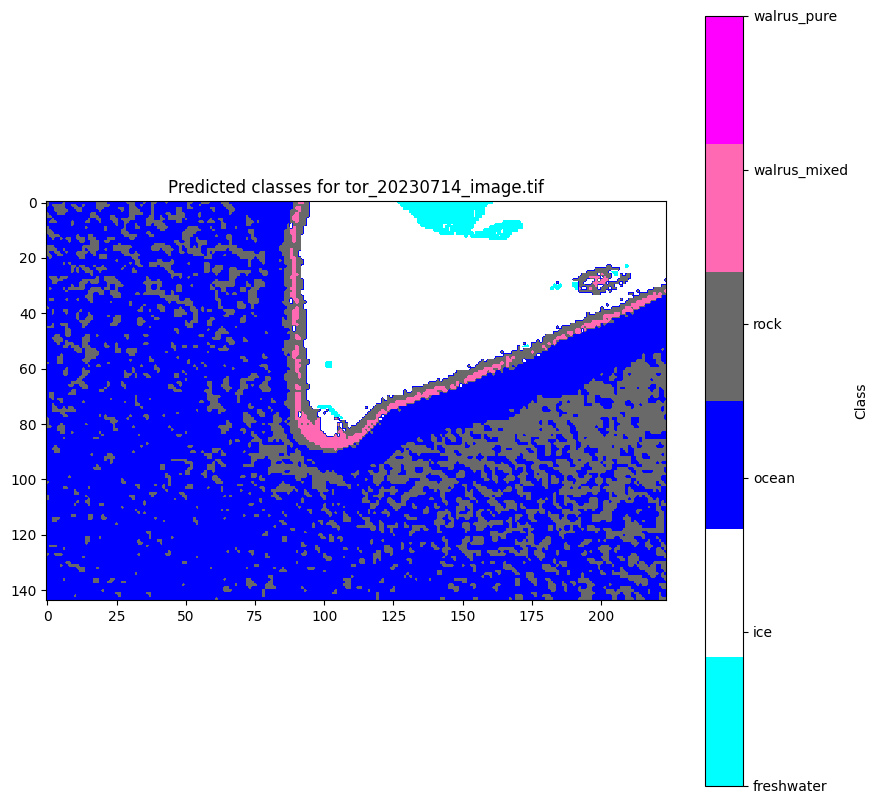

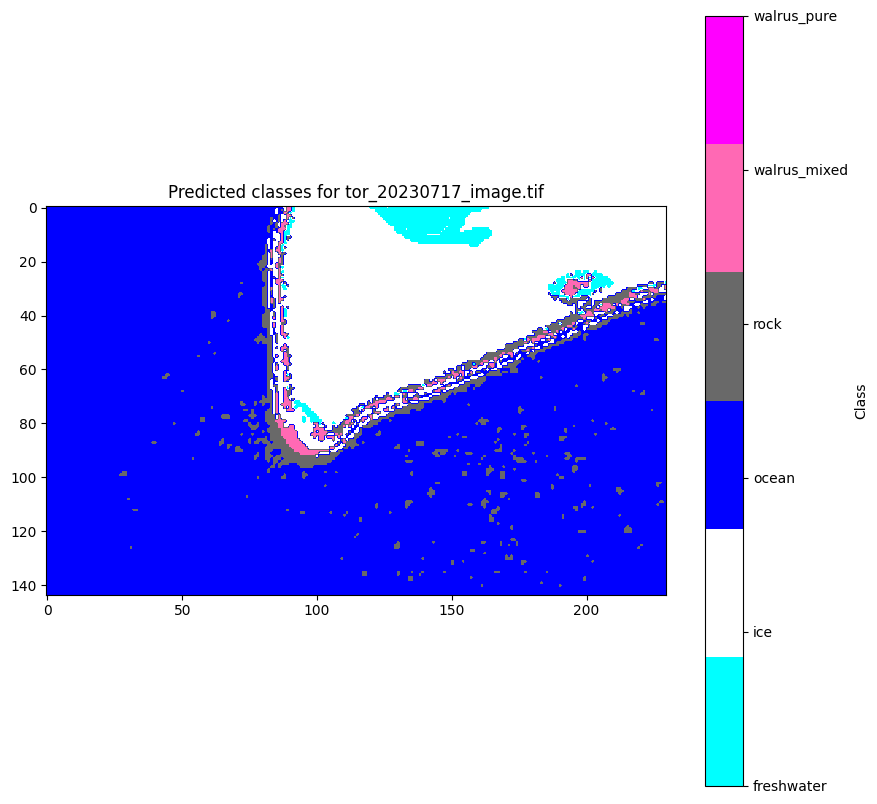

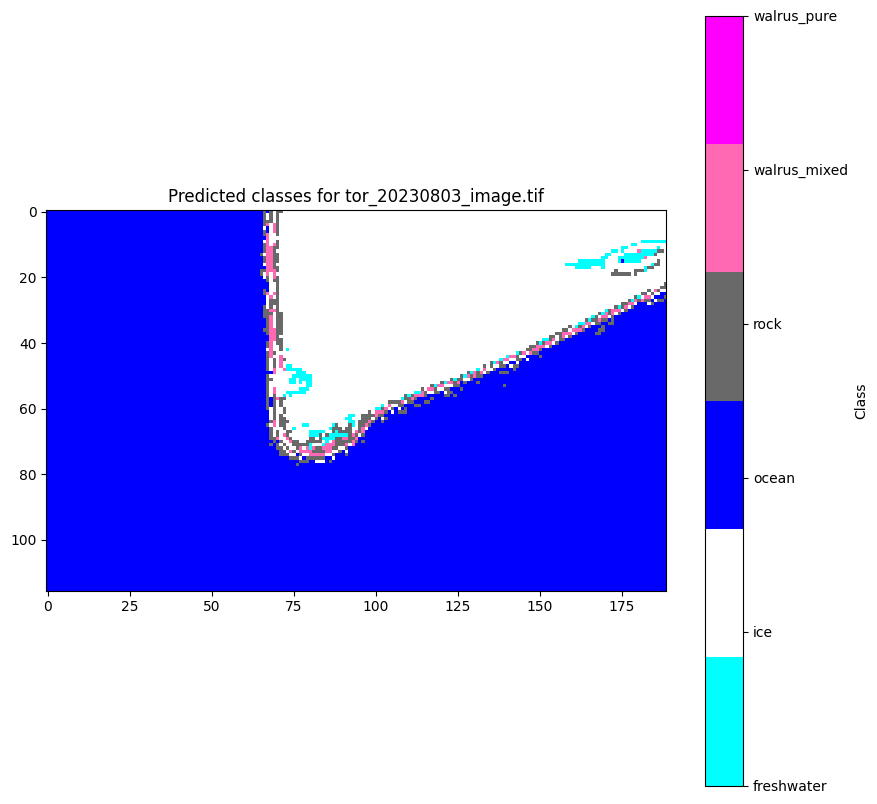

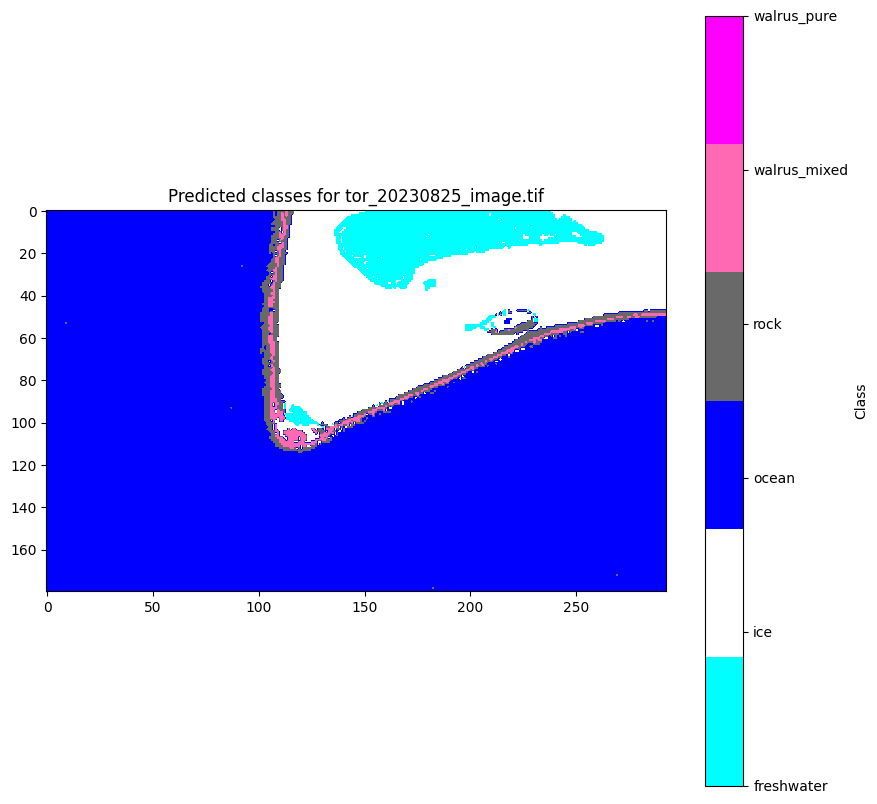

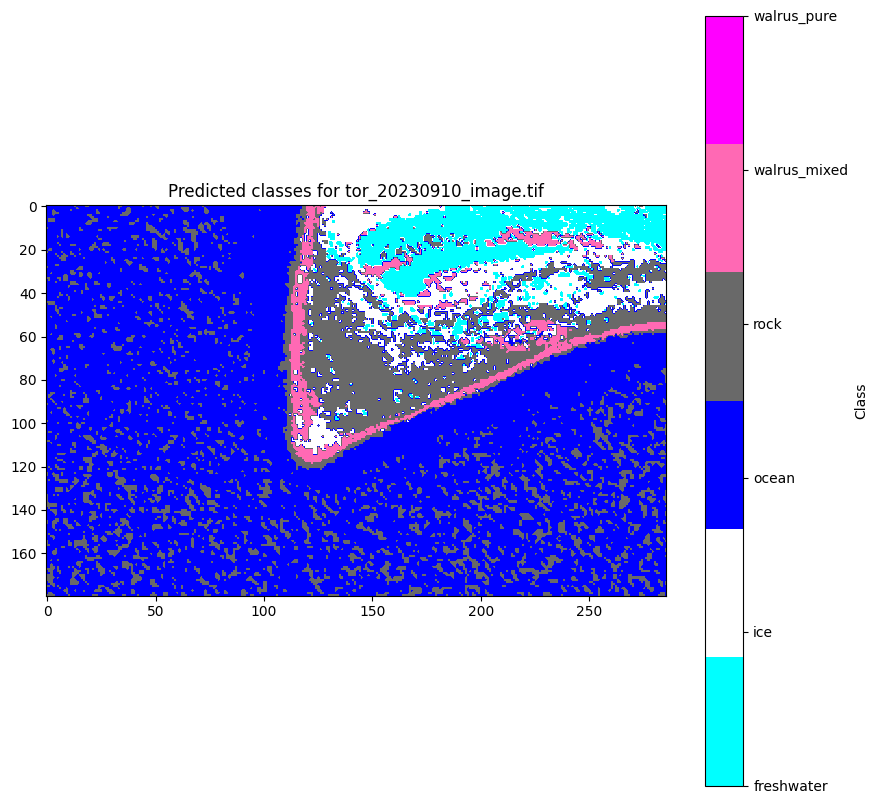

In [23]:
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()
